# 6. PSF modeling and subtraction with RDI and in presence of extended circumstellar signals

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.0.3* onwards  
> Last update: *2025/02/24*

**Table of contents**

* [6.1. Loading ADI and RDI data](#6.1.-Loading-ADI-and-RDI-data)
* [6.2. Reference star differential imaging](#6.2.-Reference-star-differential-imaging)
    - [6.2.1. median-RDI](#6.2.1.-median-RDI)
    - [6.2.2. PCA-RDI](#6.2.2.-PCA-RDI)
    - [6.2.3. PCA-ARDI](#6.2.3.-PCA-ARDI-(in-concentric-annuli))
    - [6.2.4. Contrast curves](#6.2.4.-Contrast-curves)
    - [6.2.5. NEGFC](#6.2.5.-NEGFC)
* [6.3. Strategies to mitigate self- and over-subtraction](#6.3.-Strategies-to-mitigate-self--and-over-subtraction)
    - [6.3.1. PCA-RDI with data imputation](#6.3.1.-PCA-with-data-imputation)
    - [6.3.2. Iterative PCA](#6.3.2.-Iterative-PCA)
        - [6.3.2.1. NACO dataset on beta Pic](#6.3.2.1.-NACO-dataset-on-beta-Pic)
        - [6.3.2.2. JWST/NIRCam dataset on PDS 70](#6.3.2.2.-JWST/NIRCam-dataset-on-PDS-70)

This tutorial shows:

- how to load ADI-ready datacubes; 
- how to use the stellar PSF subtraction algorithms implemented in VIP leveraging the RDI strategy;
- how to mitigate self- and over-subtraction of either disk or point source signals, through data imputation or iterative (greedy) algorithms.

<div class="alert alert-block alert-info"> 
    <b>Speed tricks: </b>
<a class="anchor" id="note1"></a>

Depending on your machine, you may be able to run VIP more efficiently than with the default options:

- Most PSF subtraction routines in VIP (and some other functions) have been implemented in VIP to allow for **multiprocessing**, in order to optimally harness the power of machines equipped with multiple CPUs. Any function where the `nproc` parameter is available in its call can be run in multi-processing, with the value of `nproc` setting the requested number of CPUs to use. Instead of an integer, one can set `nproc=None` to use half of all available CPUs. For optimal results in multiprocessing, set the following environment parameters in your terminal **BEFORE** launching your Jupyter notebook:
    
`export MKL_NUM_THREADS=1`
    
`export NUMEXPR_NUM_THREADS=1`
    
`export OMP_NUM_THREADS=1`

- If a bit of interpolation at the moment of **image rotation** is not an issue for your data (instead of using the default FFT-based method implemented in VIP), and if you have `opencv` installed, you can get a significant speed gain in the image derotation that is involved in all ADI-based post-processing routines by setting `imlib = 'opencv'` in your call to the routine. Experience suggests that up to a factor 30x in speed gain can be achieved, see however Tutorial 8 for the impact of such assumption).

- If you have **FORTRAN** installed, it is recommended to switch the default mode considered for singular value decomposition done in all PCA-based algorithms to `svd_mode = 'arpack'`, instead of the default `'lapack'` based on numpy. Experience suggests up to a factor 2x in speed gain can be achieved.
 
- If you have access to a **GPU** and large image data cubes, you may want to attempt singular value decomposition calculation on GPU by setting `svd_mode` to an appropriate value for your machine (e.g. `'cupy'` or `'eigencupy'` to leverage the Cupy library for a similar SVD as performed with the 'Lapack' and 'eigen' options, respectively; `'pytorch'` or `'eigenpytorch'` : to leverage the Pytorch library for a similar SVD as performed with the 'Lapack' and 'eigen' options, respectively). See docstrings of ``vip_hci.config.paramenum.SvdMode`` for details.

</div>

Let's first define below the set of parameters you want to use for post-processing routines called in this notebook:

In [1]:
imlib = 'vip-fft'     # Can be 'opencv' or 'skimage' for faster image rotation. Note 'vip-fft' is recommended for optimal results with iterative algorithms (see e.g. Tuto 8). 
interpolation = None  # Can be set to 'lanczos4' if you select 'opencv' above, or 'biquintic' for 'skimage'
svd_mode = 'lapack'   # How the SVD is calculated for PCA-based routines. Other alternative: 'arpack' (a bit faster than lapack, but sometimes behave strangely)
nproc = None          # int or None, None defaults to half the number of available CPUs. Set to 1 to avoid multiprocessing.

Let's now import a couple of external packages needed in this tutorial:

In [2]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes  # plotting routines
from matplotlib import pyplot as plt
from multiprocessing import cpu_count
import numpy as np
from packaging import version

In the following box we check that your version of VIP is recent enough.

In [3]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.3 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.5


## 6.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the datacube, associated parallactic angles and non-coronagraphic PSF:

In [4]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
# f1 = download_file("{}/naco_betapic_cube_cen.fits".format(url_d), cache=True)
# f2 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)
# f1 = download_file("{}/naco_betapic_nc_cube.fits".format(url_d), cache=True)
# f2 = download_file("{}/naco_betapic_nc_derot_angles.fits".format(url_d), cache=True)
# f3 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
# f1b = download_file("{}/nircam_PDS70_cube_F187N.fits".format(url_d), cache=True)
# f2b = download_file("{}/nircam_PDS70_pa_F187N.fits.fits".format(url_d), cache=True)
# f1c = download_file("{}/nircam_PDS70_cube_F480M.fits".format(url_d), cache=True)
# f2c = download_file("{}/nircam_PDS70_pa_F480M.fits.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube.fits'
f1 = '../datasets/naco_betapic_cube_cen.fits'
f2 = '../datasets/naco_betapic_derot_angles.fits'
f3 = '../datasets/naco_betapic_psf.fits'
f1b = '../datasets/nircam_PDS70_cube_F187N.fits'
f2b = '../datasets/nircam_PDS70_pa_F187N.fits'
f1c = '../datasets/nircam_PDS70_cube_F480M.fits'
f2c = '../datasets/nircam_PDS70_pa_F480M.fits'

# NACO dataset on beta Pic
cube = open_fits(f1)
angs = open_fits(f2)
psf = open_fits(f3)

# NIRCam dataset on PDS 70
cube_f187, head187 = open_fits(f1b, header=True)
angs_f187 = open_fits(f2b)
cube_f480, head480 = open_fits(f1c, header=True)
angs_f480 = open_fits(f2c)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (61,)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data and header successfully loaded. Data shape: (2, 31, 31)
FITS HDU-0 data successfully loaded. Data shape: (2,)
FITS HDU-0 data and header successfully loaded. Data shape: (2, 51, 51)
FITS HDU-0 data successfully loaded. Data shape: (2,)


For the purpose of illustrating RDI capabilities in VIP, let's just define a fiducial reference cube as the science cube flipped along both the x and y axes.
Normally you should load it the same way as your science cube.

In [5]:
cube_ref = np.flip(cube, axis=1)       # just for the example
cube_ref = np.flip(cube_ref, axis=2)

Let's fit the PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

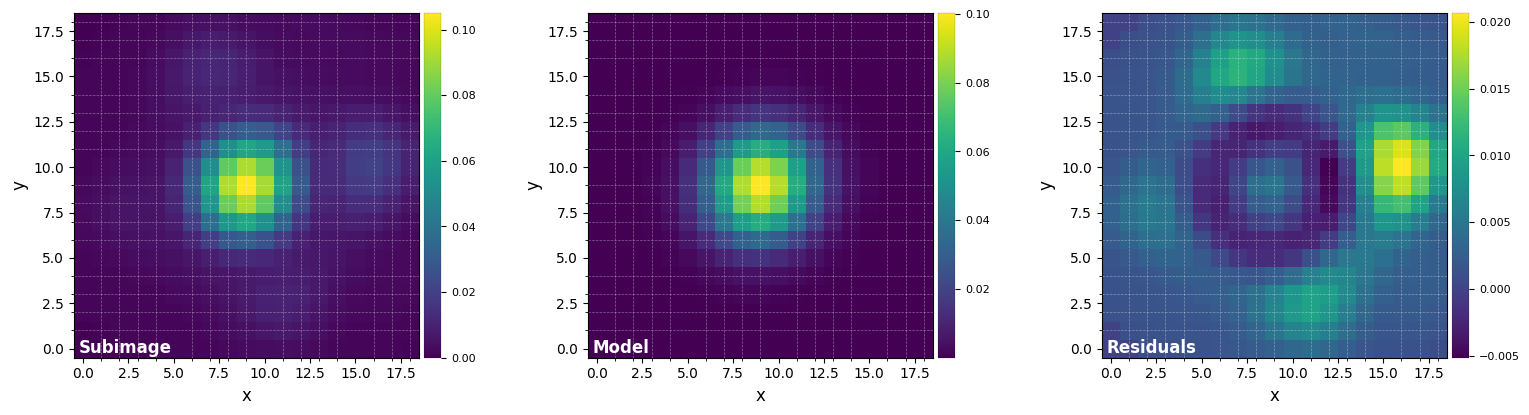

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307


In [6]:
%matplotlib inline
from vip_hci.fm import normalize_psf
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)

In [7]:
print(fwhm_naco)

4.800919383981533


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The `normalize_psf` function performs internally a fine centering of the PSF. The input PSF should nevertheless already be centered within a few pixel accuracy for the fine centering to work.
</div>

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` (default) allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

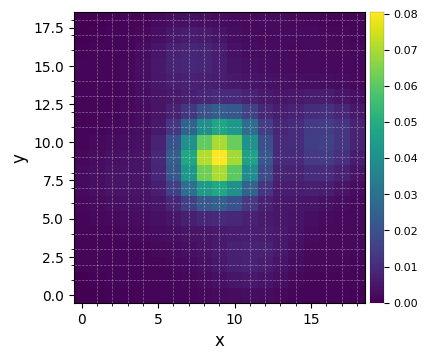

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for the different datasets: 
- for NACO (L' band), we get it from a dictionary stored in the `conf` subpackage;
- for the NIRCam F187N and F480M data, we get it from the header.

In [9]:
from vip_hci.config import VLT_NACO
pxscale_naco = VLT_NACO['plsc']
print("NACO pixel scale:", pxscale_naco, "arcsec/px")

pxscale_f187 = np.sqrt(float(head187['PIXAR_A2']))  # sqrt of area per pixel in arcsec^2
print("NIRCam F187N pixel scale:", pxscale_f187, "arcsec/px")
pxscale_f480 = np.sqrt(float(head480['PIXAR_A2']))  # sqrt of area per pixel in arcsec^2
print("NIRCam F480M pixel scale:", pxscale_f480, "arcsec/px")

NACO pixel scale: 0.02719 arcsec/px
NIRCam F187N pixel scale: 0.030745731411043063 arcsec/px
NIRCam F480M pixel scale: 0.06300793600809346 arcsec/px


## 6.2. Reference-star differential imaging

<div class="alert alert-block alert-warning"> 
    <b>Important: </b>
<a class="anchor" id="war1"></a>

In all post-processing methods of VIP, **Reference-star Differential Imaging** is triggered whenever a 3D reference cube of PSF images is provided with the optional parameter ``cube_ref``, be it for PSF subtraction or forward modeling. In almost all cases, ``cube_ref`` triggers **RDI** only (i.e., the science cube of images is not used to create the PSF model). The only exceptions are the ``pca_annular`` and ``nmf_annular`` functions, where providing a reference cube triggers by default **ARDI** (i.e., using both the reference cube **and** the images of the science cube which match the rotation threshold defined by ``delta_rot``). For RDI-only annular PCA/NMF reductions, one can simply increase the value of ``delta_rot`` to an arbitrarily large value (e.g., 100).
</div>

### 6.2.1. median-RDI

The most straightforward way to leverage a stack of reference PSF images is to consider its median image as PSF model, and subtract it to each image of the science cube. This can be done with the `median_sub` function:

In [10]:
from vip_hci.psfsub import median_sub
med_rdi = median_sub(cube, angs, cube_ref=cube_ref, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:45
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.615912
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results, after masking the central 13 px of the image.

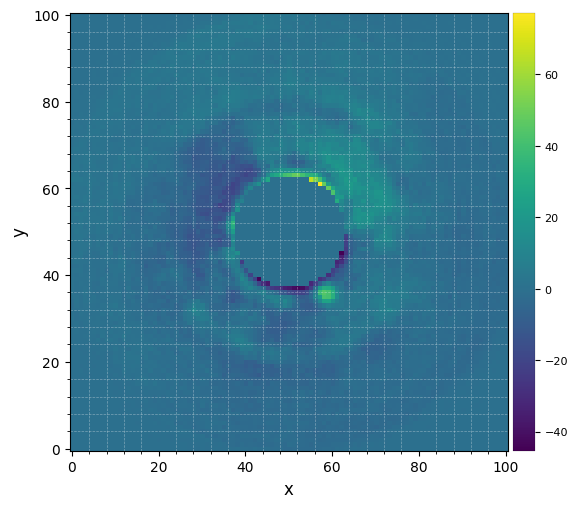

In [11]:
from vip_hci.var import mask_circle
plot_frames(mask_circle(med_rdi, 13), grid=True)

As can be seen above, this approach is sufficient to detect exoplanet beta Pic b towards the bottom right of the image (after masking the central part of the image)! This is not too bad, considering we only considered as fake reference cube the science images flipped horizontally and vertically.

The default behaviour will subtract the median reference image of the reference stack however other options can be used. Although the median is more robust, the mean of the reference stack can be requested instead:

In [12]:
mean_rdi = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='mean', nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:46
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.607196
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Alternatively, the mean/median reference image can be scaled to match in flux each science image before subtraction - this can be useful if the reference image is known to be brighter or fainter than the science image:

In [13]:
med_rdi_sc = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='sc_median', nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.615464
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


By default when scaling is requested, the scaling factor is calculating from integrating the flux on the whole science and reference images. But an inner and outer radius can be provided, which can be relevant if a coronagraph is used or contamination is present at large radius, respectively. This is done by adding 2 numbers directly at the end of the ``collapse_ref`` string, separated by '-'. For example, if we want to consider an annulus going from 1 to 3 FWHM for this coronagraphic NaCo dataset (FWHM ~ 5pixels), we can set:

In [14]:
med_rdi_sc515 = median_sub(cube, angs, cube_ref=cube_ref, collapse_ref='sc_median5-15', nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:47
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.610559
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Alternatively, median-RDI can be applied in concentric annuli with a scaling factor calculated per annulus. This is controlled with the ``mode`` argument (set to 'fullfr' by default). The width of the concentric annuli is set in pixels using argument `asize`, and the radius of the first annuli is set with ``radius_int``. Let's set both to the FWHM.

In [15]:
med_rdi_ann = median_sub(cube, angs, mode='annular', asize=fwhm_naco, radius_int=fwhm_naco,
                         cube_ref=cube_ref, collapse_ref='sc_median', nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 9, FWHM = 4
Processing annuli: with 5 processes
Optimized median psf reference subtracted
Done derotating and combining
Running time:  0:00:00.659595
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's now visualize all the results obtained above, without any numerical mask:

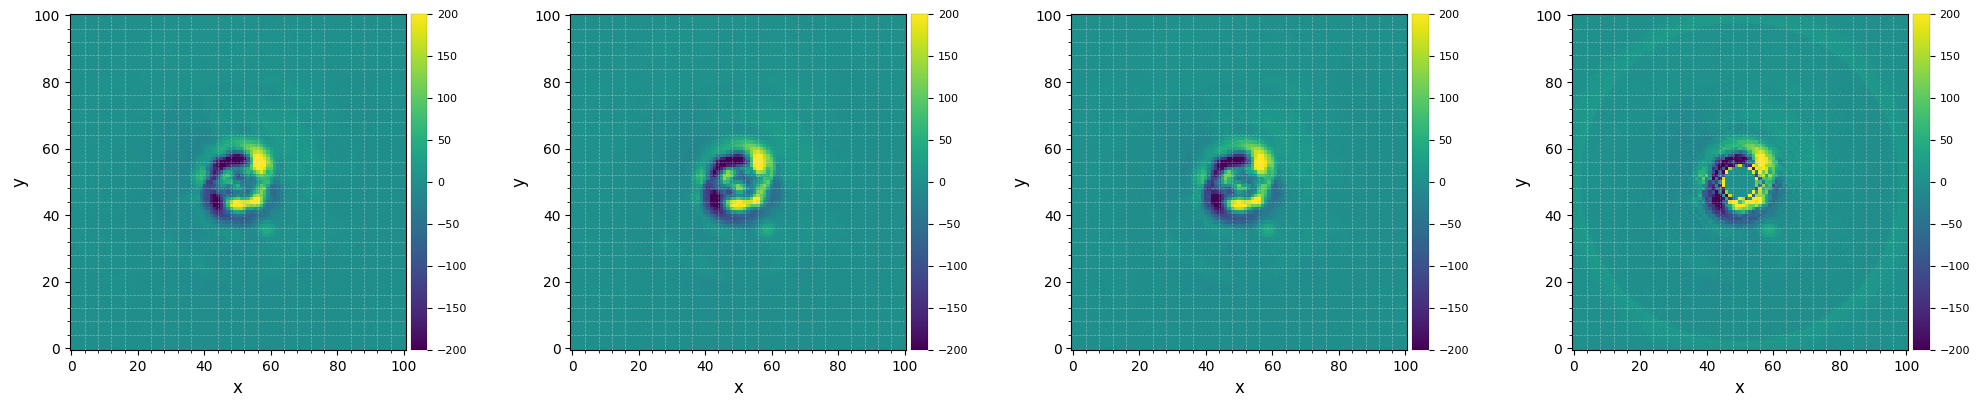

In [16]:
plot_frames((mean_rdi, med_rdi_sc, med_rdi_sc515, med_rdi_ann), vmin=-200, vmax=200, grid=True)

As expected the results obtained with the different ``collapse_ref`` options are very similar -- since here we used as fake reference cube the flipped science cube. We also notice strong residuals near the center of the image which shows the limitation of assuming a perfect centro-symmetry stellar halo. Nonetheless the signature of beta Pic b can be seen towards the bottom right of the image.

### 6.2.2. PCA-RDI

Using PCA leveraging the RDI strategy is as simple as calling the `pca` function in VIP with the `cube_ref` argument set to your cube of reference images. For example, to run PCA using 42 principal components:

In [17]:
from vip_hci.psfsub import pca

svd_mode = 'lapack'   # you may want to set it to 'arpack' if you have FORTRAN installed -- see speed trick box
pca_rdi_fr = pca(cube, angs, ncomp=25, cube_ref=cube_ref, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.734 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.039352
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:00.655293
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's visualize the results, after masking the central 13 px of the image.

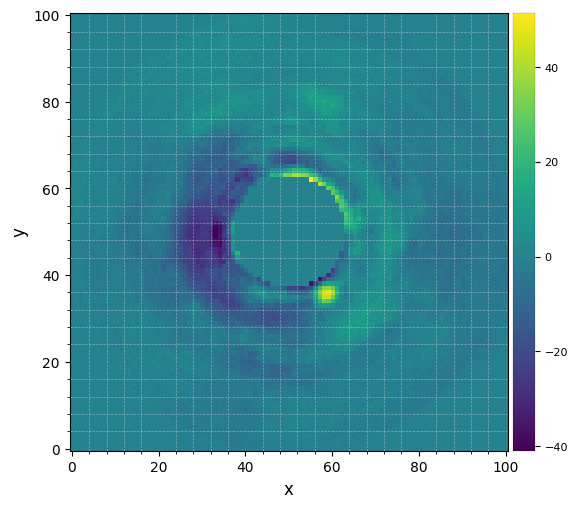

In [18]:
from vip_hci.var import mask_circle
plot_frames(mask_circle(pca_rdi_fr, 13), grid=True)

We now see Beta Pic b a bit clearer than with the median-subtraction approach.

A lot of options are available with the PCA function, and are also relevant with a reference cube. We refer to [Tutorial 3 (section 3.5)](https://vip.readthedocs.io/en/latest/tutorials/03A_psfsub_ADI.html#3.5.-Principal-Component-Analysis-(PCA)), for all available options. Below we just illustrate the use of a convenient function providing the SNR of a candidate as a function of number of principal components.

Let's first define the approximate coordinates of the companion based on the image above (remember to subtract 1 to the coordinates read in the image since Python uses a zero-based index system):

In [19]:
xy_b = (58, 35)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:14:50
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.038584
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 51
Optimal number of PCs = 16, for S/N=3.633
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 58.0, 35.0
Flux in a centered 1xFWHM circular aperture = 421.081
Central pixel S/N = 5.655
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 3.633
Max S/N (shifting the aperture center) = 5.796
stddev S/N (shifting the aperture center) = 1.473



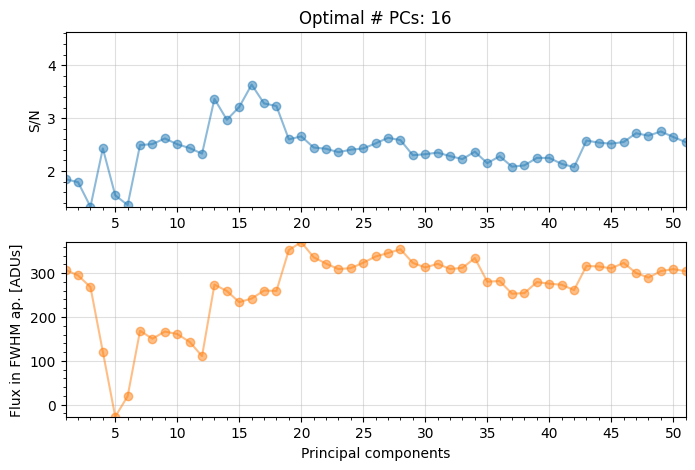

In [20]:
from vip_hci.psfsub import pca_grid
pca_rdi_opt = pca_grid(cube, angs, cube_ref=cube_ref, fwhm=fwhm_naco, range_pcs=(1,51,1),
                       source_xy=xy_b, mode='fullfr', full_output=True, plot=True, svd_mode=svd_mode, nproc=nproc)

### 6.2.3. PCA-ARDI

One can leverage *both* ADI and RDI in cases where there is enough field rotation in your science cube and a cube of reference images is available. This is referred to as *ARDI*. PCA-ARDI is most easily done by calling the `pca_annular` function in VIP, with the `cube_ref` argument set to your cube of reference images. The latter is a bit slow, so a trick for a faster usage in full-frame is also provided further below.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

Mind the different **default** behaviours of the `pca` and `pca_annular` functions when provided a `cube_ref` reference cube. `pca` will adopt by default a **RDI**-only strategy (i.e., not use the science images to calculate the principal components), while `pca_annular` will *by default* follow an **ARDI** strategy (i.e., use both the reference images and the science images that meet a certain rotation threshold to calculate the principal components associated to each image of the cube).
</div>

First let's consider PCA-ARDI in concentric annuli with a width set to the FWHM, using 13 principal components. By default, the rotation threshold used to accept science images in the PCA library increases from 0.1 FWHM to 1.0 FWHM from the innermost to the outermost annulus, respectively. This threshold can be adapted with the `delta_rot` parameter.

In [21]:
from vip_hci.psfsub import pca_annular
asize = cube.shape[-1]//2 - 1

pca_ardi_fr = pca_annular(cube, angs, ncomp=13, asize=fwhm_naco, fwhm=fwhm_naco,
                          cube_ref=cube_ref, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 10, FWHM = 4.801
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 11.42    Ann center:   2    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.053646
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  7.63    Ann center:   7    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.130200
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  6.87    Ann center:  12    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.221895
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.54    Ann center:  17    N segments: 1 
Done PCA with lapack for curr

Let's visualize the results, after masking the central 1 FWHM in the image.

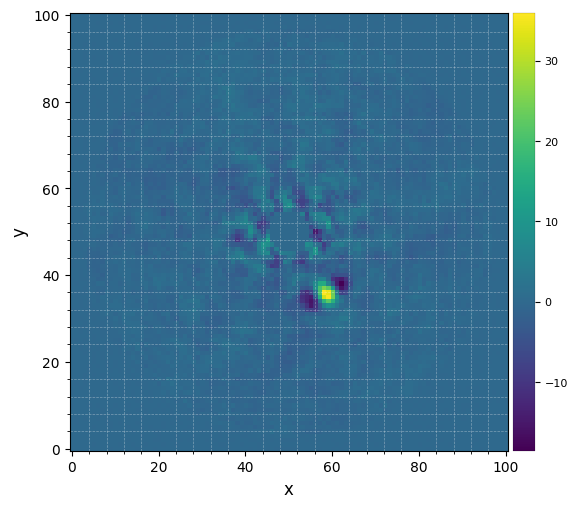

In [22]:
plot_frames(mask_circle(pca_ardi_fr, fwhm_naco), grid=True)

We now see Beta Pic b much clearer - with a result more similar to PCA-ADI ([Tutorial 3 - Section 3.5](https://vip.readthedocs.io/en/latest/tutorials/03A_psfsub_ADI.html#3.5.-Principal-Component-Analysis-(PCA))).

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The `delta_rot` parameter is expressed in FWHM units, and corresponds to the amount of required linear motion (in pixels) at the middle of each concentric annulus. A single value, a tuple of 2 elements, or a list of `n_annuli` values, can be provided for that argument corresponding to: a single threshold in rotation to be used for all annuli, the lower and upper bounds of a linearly increasing rotation threshold, and the exact rotation threshold to be used for each of all concentric annuli, respectively.
</div>

Let's consider a few example cases - the most relevant choice for you will depend on your data:

* **ARDI** using all science and reference images in the PCA library, in 2 concentric annuli:

In [23]:
pca_ardi_all_fr = pca_annular(cube, angs, ncomp=13, asize=asize, cube_ref=cube_ref,
                              delta_rot=0, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 1, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    Ann center:  24    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:01.066731
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:01.625233
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* Pure **RDI** in 2 concentric annuli. This is done by setting `delta_rot` to an arbitrarily high value for no science image to meet the criterion for inclusion in the PCA library.

In [24]:
pca_rdi_ann_fr = pca_annular(cube, angs, ncomp=13, asize=asize, cube_ref=cube_ref,
                             delta_rot=100, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 1, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh: 166.60    Ann center:  24    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.349961
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:00.904151
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* **ARDI** in a single annulus, with a rotation threshold of 1 FWHM for inclusion of the science images to the PCA library:

In [25]:
asize1 = cube.shape[-1]//2 - 1
pca_ardi_thr1 = pca_annular(cube, angs, ncomp=13, asize=asize1, cube_ref=cube_ref,
                            delta_rot=1, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:25
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 1, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  9.73    Ann center:  24    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.877169
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done derotating and combining.
Running time:  0:00:01.447007
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


* **ARDI** in 4 concentric annuli, with a rotation threshold linearly increasing from 0.2 FWHM for the innermost annulus up to 1 FWHM for the outermost annulus:

In [26]:
asize4 = cube.shape[-1]//8 - 1
pca_ardi_ann4 = pca_annular(cube, angs, ncomp=13, asize=asize4, cube_ref=cube_ref,
                            delta_rot=[0.1, 0.25, 0.5, 1], svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
N annuli = 4, FWHM = 4.000
PCA per annulus (or annular sectors):
Ann 1    PA thresh:  4.17    Ann center:   6    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.104143
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 2    PA thresh:  3.47    Ann center:  16    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.299889
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 3    PA thresh:  4.17    Ann center:  28    N segments: 1 
Done PCA with lapack for current annulus
Running time:  0:00:00.580661
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Ann 4    PA thresh:  6.11    Ann center:  38    N segments: 1 
Done PCA with lapack for curre

* **ARDI** in full-frame considering all science and reference images (the **fastest** of all available options for ARDI). Here the trick is to redefine the reference cube to be a concatenation of the original science and reference cubes before passing it to the `pca` function:

In [27]:
cube_ref_tmp = np.concatenate((cube, cube_ref))
pca_ardi_full = pca(cube, angs, ncomp=13, cube_ref=cube_ref_tmp, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:28
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.884 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done vectorizing the frames. Matrix shape: (122, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.129334
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:00.687715
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

If you run ARDI without any threshold in rotation on the science images, you may get very similar results to either ADI or RDI depending on the relative number of science and reference images in each cube, as the larger image stack will dominate the principal components.
</div>

Let's visualize the results. For this, let's first place all the processed images in a numpy array, and mask the inner 10px of each image: 

In [28]:
pca_ardi_res = np.array((pca_ardi_fr, pca_ardi_all_fr, pca_rdi_ann_fr,
                         pca_ardi_thr1, pca_ardi_ann4, pca_ardi_full))
labels = ('PCA-ARDI (npc=13, default)', 'PCA-ARDI (npc=13, all ref and sci)', 'PCA-RDI (npc=13)',
          r'PCA-ARDI (1 ann, $\delta \theta$=1FWHM)', r'PCA-ARDI (4 ann, $\delta \theta$=0.2-1FWHM)', 'PCA-ARDI (full-frame)')
pca_ardi_res_mask = mask_circle(pca_ardi_res, 12)

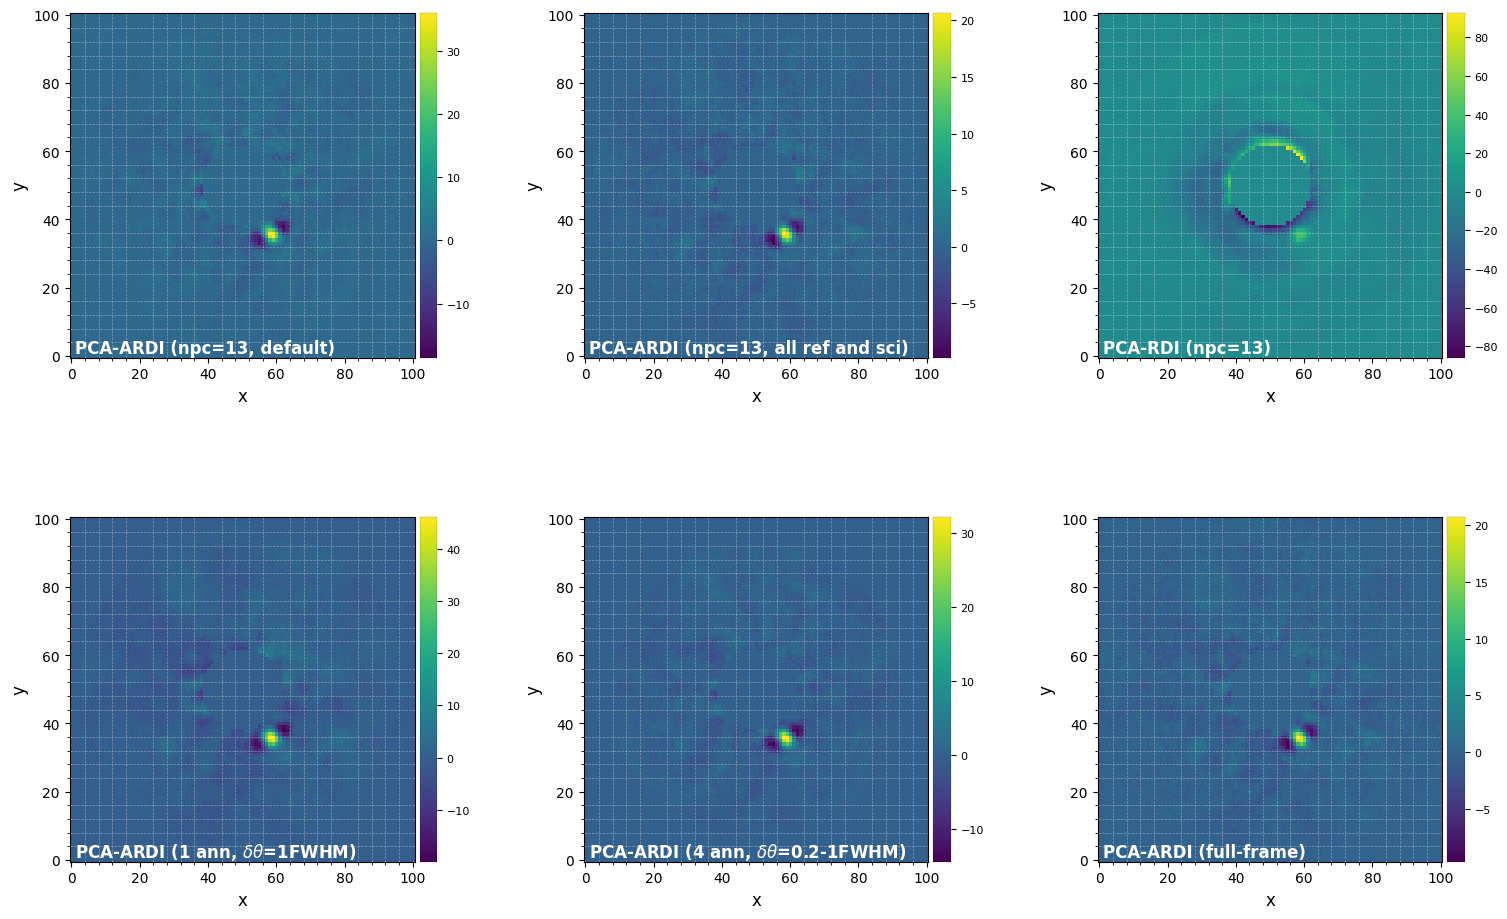

In [29]:
plot_frames(pca_ardi_res_mask, rows=2, label=labels, grid=True)

Remember that the optimal strategy and relative weighting of science vs reference images will depend on the data at hand... Is a lot of field rotation available? Are the reference images well correlated to the science images? Do the radial profile of the reference and science PSF match?

### 6.2.4. Contrast curves

Let's now calculate and compare contrast curves obtained with PCA-ADI, PCA-RDI and PCA-ARDI for this dataset. For simplicity, we'll just consider a single set-up for each case in terms of number of principal components and rotation threshold.

Note that the correct way to do this is to first estimate the parameters of any companion (see [Tutorial 5A](https://vip.readthedocs.io/en/latest/tutorials/05A_fm_planets.html)) and remove the companion from the data. We quickly do this with the `cube_planet_free` function in the next cell, considering the parameters of beta Pic b reported in Absil et al. (2013).

In [30]:
from vip_hci.fm import cube_planet_free

r_b =  0.452/pxscale_naco # Absil et al. (2013)
theta_b = 211.2+90 # Absil et al. (2013)
f_b = 648.2

cube_emp = cube_planet_free([(r_b, theta_b, f_b)], cube, angs, psfn=psfn)

Among the parameters of the `contrast_curve` function, one needs to provide `starphot` which corresponds to the (expected) flux of the star in the coronagraphic images. The latter can be obtained from the non-coronagraphic PSF (e.g. through the `normalize_psf` function), and after rescaling this flux to the integration time ratio used for the coronagraphic vs non-coronagraphic observations. Let's assume here that this task was done separately:

In [31]:
starphot = 764939.6

Another relevant parameter of the contrast curve function is ``algo``, which takes any function in ``VIP`` for model PSF subtraction, or a user-defined imported function. Optional parameters of the `algo` can also be passed as regular parameters of `contrast_curve`.

Let's now calculate the contrast curves: 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca, FWHM = 4.800919383981533, # BRANCHES = 3, SIGMA = 5, STARPHOT = 764939.6
Finished the throughput calculation
Running time:  0:00:12.000940
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:15:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
ALGO : pca_annular, FWHM = 4.800919383981533, # BRANCHES = 3, SIGMA = 5, STARPHOT = 764939.6
Finished the throughput calculation
Running time:  0:00:22.014141
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:16:04
――――――――――――――――――

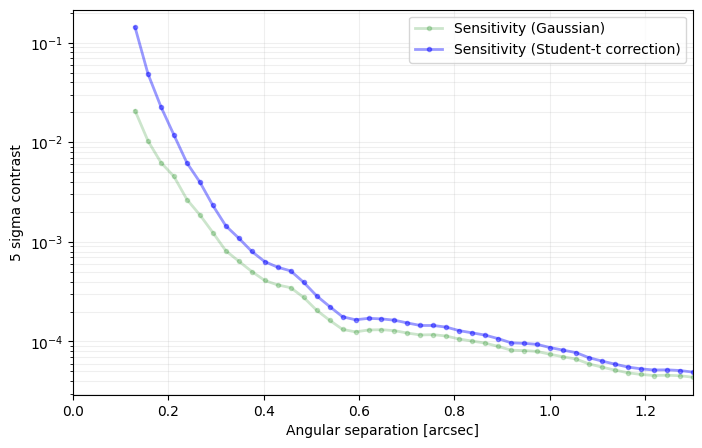

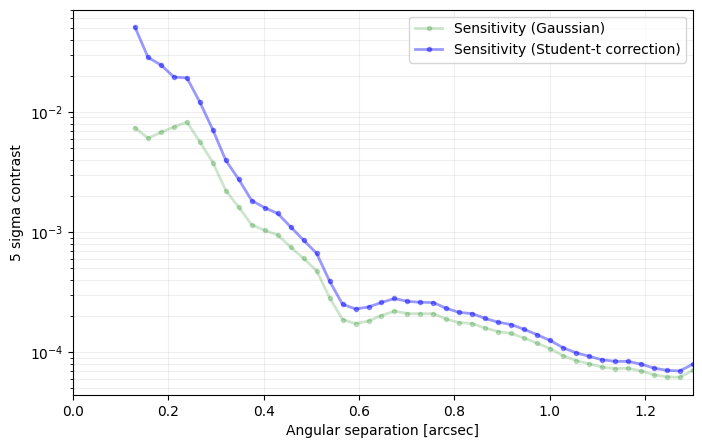

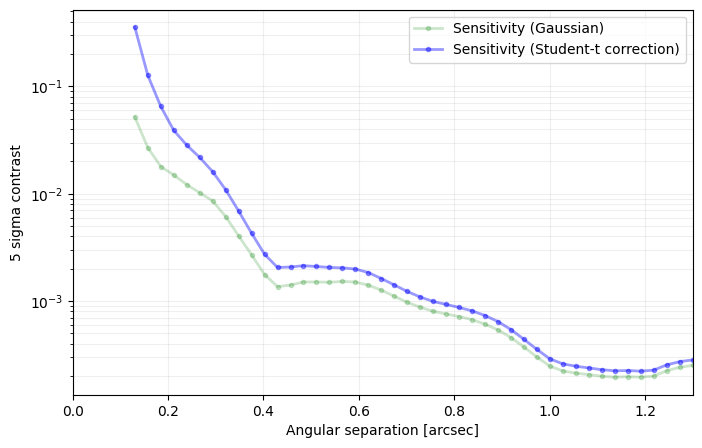

In [32]:
from vip_hci.metrics import contrast_curve
cc_adi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=10, svd_mode=svd_mode, nproc=nproc)
cc_ardi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                         sigma=5, nbranch=3, algo=pca_annular, ncomp=25, cube_ref=cube_ref, asize=asize,
                         delta_rot=0, svd_mode=svd_mode, nproc=nproc)
cc_rdi = contrast_curve(cube_emp, angs, psfn, fwhm=fwhm_naco, pxscale=pxscale_naco, starphot=starphot, 
                        sigma=5, nbranch=3, algo=pca, ncomp=50, cube_ref=cube_ref, svd_mode=svd_mode, nproc=nproc)

Let's now compare the 3 contrast curves in a single plot, and also place Beta Pic b in the plot:

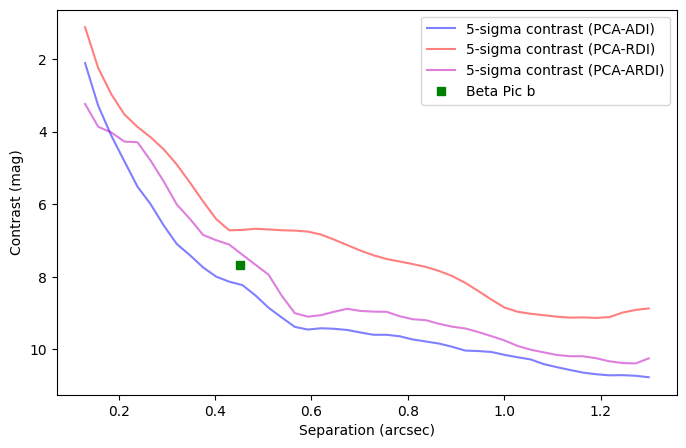

In [33]:
plt.figure(figsize=(8,5))
plt.plot(cc_adi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_adi['sensitivity_student']), 
         'b-', label='5-sigma contrast (PCA-ADI)', alpha=0.5)
plt.plot(cc_rdi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_rdi['sensitivity_student']), 
         'r-', label='5-sigma contrast (PCA-RDI)', alpha=0.5)
plt.plot(cc_ardi['distance']*pxscale_naco, 
         -2.5*np.log10(cc_ardi['sensitivity_student']), 
         'm-', label='5-sigma contrast (PCA-ARDI)', alpha=0.5)
plt.plot(r_b*pxscale_naco, 
         -2.5*np.log10(f_b/starphot), 'gs', label='Beta Pic b')
plt.gca().invert_yaxis()
plt.ylabel('Contrast (mag)')
plt.xlabel('Separation (arcsec)')
_ = plt.legend(loc='best')
plt.show()

For well-correlated reference images (not the case here with our fake reference cube), the contrast achieved with PCA-RDI can also become deeper than PCA-ADI at short separation, where little linear motion for field rotation is available.

Check out [tutorial 4](https://vip.readthedocs.io/en/latest/tutorials/04_metrics.html) for more examples of contrast curve calculations.

### 6.2.5. NEGFC

[Tutorial 5A](https://vip.readthedocs.io/en/latest/tutorials/05A_fm_planets.html) showcases in details how to use the NEGFC technique (combined with the ADI strategy) to estimate the position and flux of a directly imaged companion in your data. The typical workflow involves obtaining a first guess with a simplex algorithm, followed by using a MCMC algorithm for better estimates on the uncertainties on the parameters of the companion.

Below we just briefly illustrate how to use the NEGFC technique with the simplex (`firstguess`) algorithm for either RDI or ARDI strategies, but the same applies to the NEGFC algorithm.

First, let's inject a fake companion in the data:

In [34]:
from vip_hci.fm import cube_inject_companions
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.
gt = [rad_fc, theta_fc, flux_fc]
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1)

In [35]:
from vip_hci.var import frame_center
cy, cx = frame_center(cube[0])
xy_test = cx+rad_fc*np.cos(np.deg2rad(theta_fc)), cy+rad_fc*np.sin(np.deg2rad(theta_fc))
xy_test

(34.749999999999986, 23.58622518457463)

#### 6.2.5.1. PCA-RDI

By default, the algorithm used by NEGFC is PCA in a single annulus (`pca_annulus`) encompassing the location of the companion. This function behaves in the same way as full-frame PCA when provided with a reference cube (i.e., it triggers pure RDI). The reference cube is provided through the `algo_options` argument, which allows to provide additional arguments associated to the algorithm:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:16:17
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.098
2/30   0.149   0.098
3/30   0.221   0.098
4/30   0.329   0.098
5/30   0.489   0.098
6/30   0.728   0.098
7/30   1.083   0.098
8/30   1.610   0.097
9/30   2.395   0.097
10/30   3.562   0.097
11/30   5.298   0.096
12/30   7.880   0.095
13/30   11.721   0.094
14/30   17.433   0.092
15/30   25.929   0.090
16/30   38.566   0.086
17/30   57.362   0.081
18/30   85.317   0.074
19/30   126.896   0.065
20/30   188.739   0.055
21/30   280.722   0.047
22/30   417.532   0.054


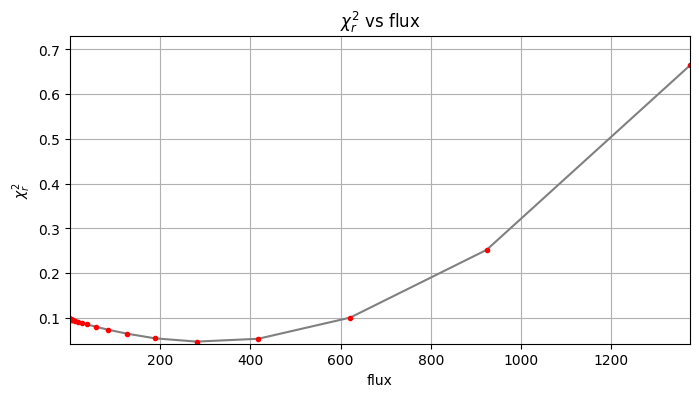

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 280.72
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 129, nfev: 284, chi2r: 0.045345033918108256
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.088, 240.241, 309.338) at 
          (X,Y)=(35.07, 23.88)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:13.703073
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [36]:
from vip_hci.fm import firstguess
r_rdi, theta_rdi, f_rdi = firstguess(cubefc, angs, psfn, cube_ref=cube_ref, ncomp=13, planets_xy_coord=[xy_test], 
                                     fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                     aperture_radius=2, simplex=True, plot=True,
                                     algo_options={'svd_mode':svd_mode}, verbose=True)

In [37]:
print("Ground truth injected parameters:", gt)
print("Estimated parameters by NEGFC (simplex):", [r_rdi[0], theta_rdi[0], f_rdi[0]])

Ground truth injected parameters: [30.5, 240, 400.0]
Estimated parameters by NEGFC (simplex): [30.087965147512023, 240.24098951381853, 309.337884867174]


#### 6.2.5.2. PCA-ARDI

To activate the ARDI strategy, one needs to use the `pca_annular` function (note the minor but important difference with `pca_annulus`). In this case, we also request a rotation threshold (`delta_rot`) to be 1 in the algorithm options dictionary.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 10:17:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.744
2/30   0.149   1.744
3/30   0.221   1.743
4/30   0.329   1.742
5/30   0.489   1.741
6/30   0.728   1.739
7/30   1.083   1.736
8/30   1.610   1.732
9/30   2.395   1.725
10/30   3.562   1.716
11/30   5.298   1.702
12/30   7.880   1.681
13/30   11.721   1.650
14/30   17.433   1.604
15/30   25.929   1.536
16/30   38.566   1.438
17/30   57.362   1.304
18/30   85.317   1.116
19/30   126.896   0.840
20/30   188.739   0.532
21/30   280.722   0.207
22/30   417.532   0.045


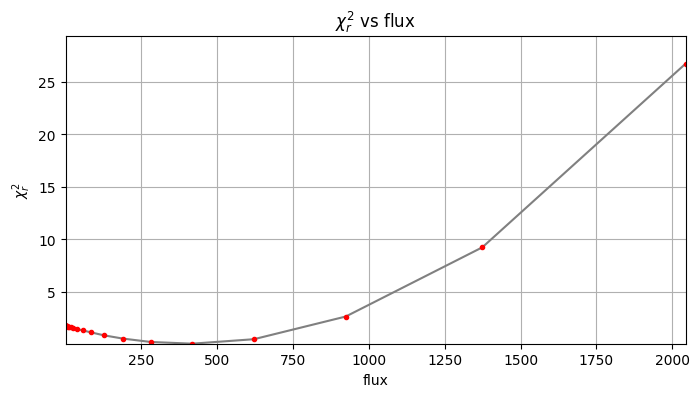

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.53
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 85, nfev: 181, chi2r: 0.04189390587889774
message: Optimization terminated successfully.
Planet 0 simplex result: (r, theta, f)=(30.462, 240.159, 411.489) at 
          (X,Y)=(34.84, 23.58)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:43:25.689517
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [38]:
r_ardi, theta_ardi, f_ardi = firstguess(cubefc, angs, psfn, cube_ref=cube_ref, ncomp=13, planets_xy_coord=[xy_test], 
                                        fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                        aperture_radius=2, simplex=True, plot=True, algo=pca_annular,
                                        algo_options={'svd_mode':svd_mode, 'delta_rot':1, 'verbose':False}, 
                                        verbose=True)

In [39]:
print("Ground truth injected parameters:", gt)
print("Estimated parameters by NEGFC (simplex):", [r_ardi[0], theta_ardi[0], f_ardi[0]])

Ground truth injected parameters: [30.5, 240, 400.0]
Estimated parameters by NEGFC (simplex): [30.46223223398893, 240.1587327841831, 411.4888353300621]


The estimated parameters obtained with NEGFC (PCA-ARDI) are much closer to the ground truth than those obtained with NEGFC (PCA-RDI). Similarly to what is shown in Tutorial 05, one can also run the NEGFC with an MCMC sampling.

## 6.3. Strategies to mitigate self- and over-subtraction

**Self-subtraction** arises when circumstellar signals (disk or planet) are present in the library of images used to learn a model PSF for subtraction. When the components (principal components for PCA, NMF components, etc.) contain circumstellar signals and are projected onto the science images to produce a model PSF, circumstellar signals get partly *self-subtracted*. This typically happens with the angular or spectral differential imaging strategies.

**Over-subtraction** arises when components are projected onto science images which contain circumstellar signals, regardless of whether the components contain circumstellar signals or not. The issue arises from a mis-estimation of the projection factors due to the presence of circumstellar signals in the images onto which the components are projected. This effect can happen for any differential strategy, including reference-star differential imaging.

**Self- and over-subtraction can lead to geometric biases in the case of extended disk signals.** This means that the original morphology of extended disk signals gets distorted (Milli et al. 2012; Christiaens et al. 2019; Juillard et al. 2022). This section explores strategies available in VIP to mitigate these distortions, such as data imputation or iterative algorithms.

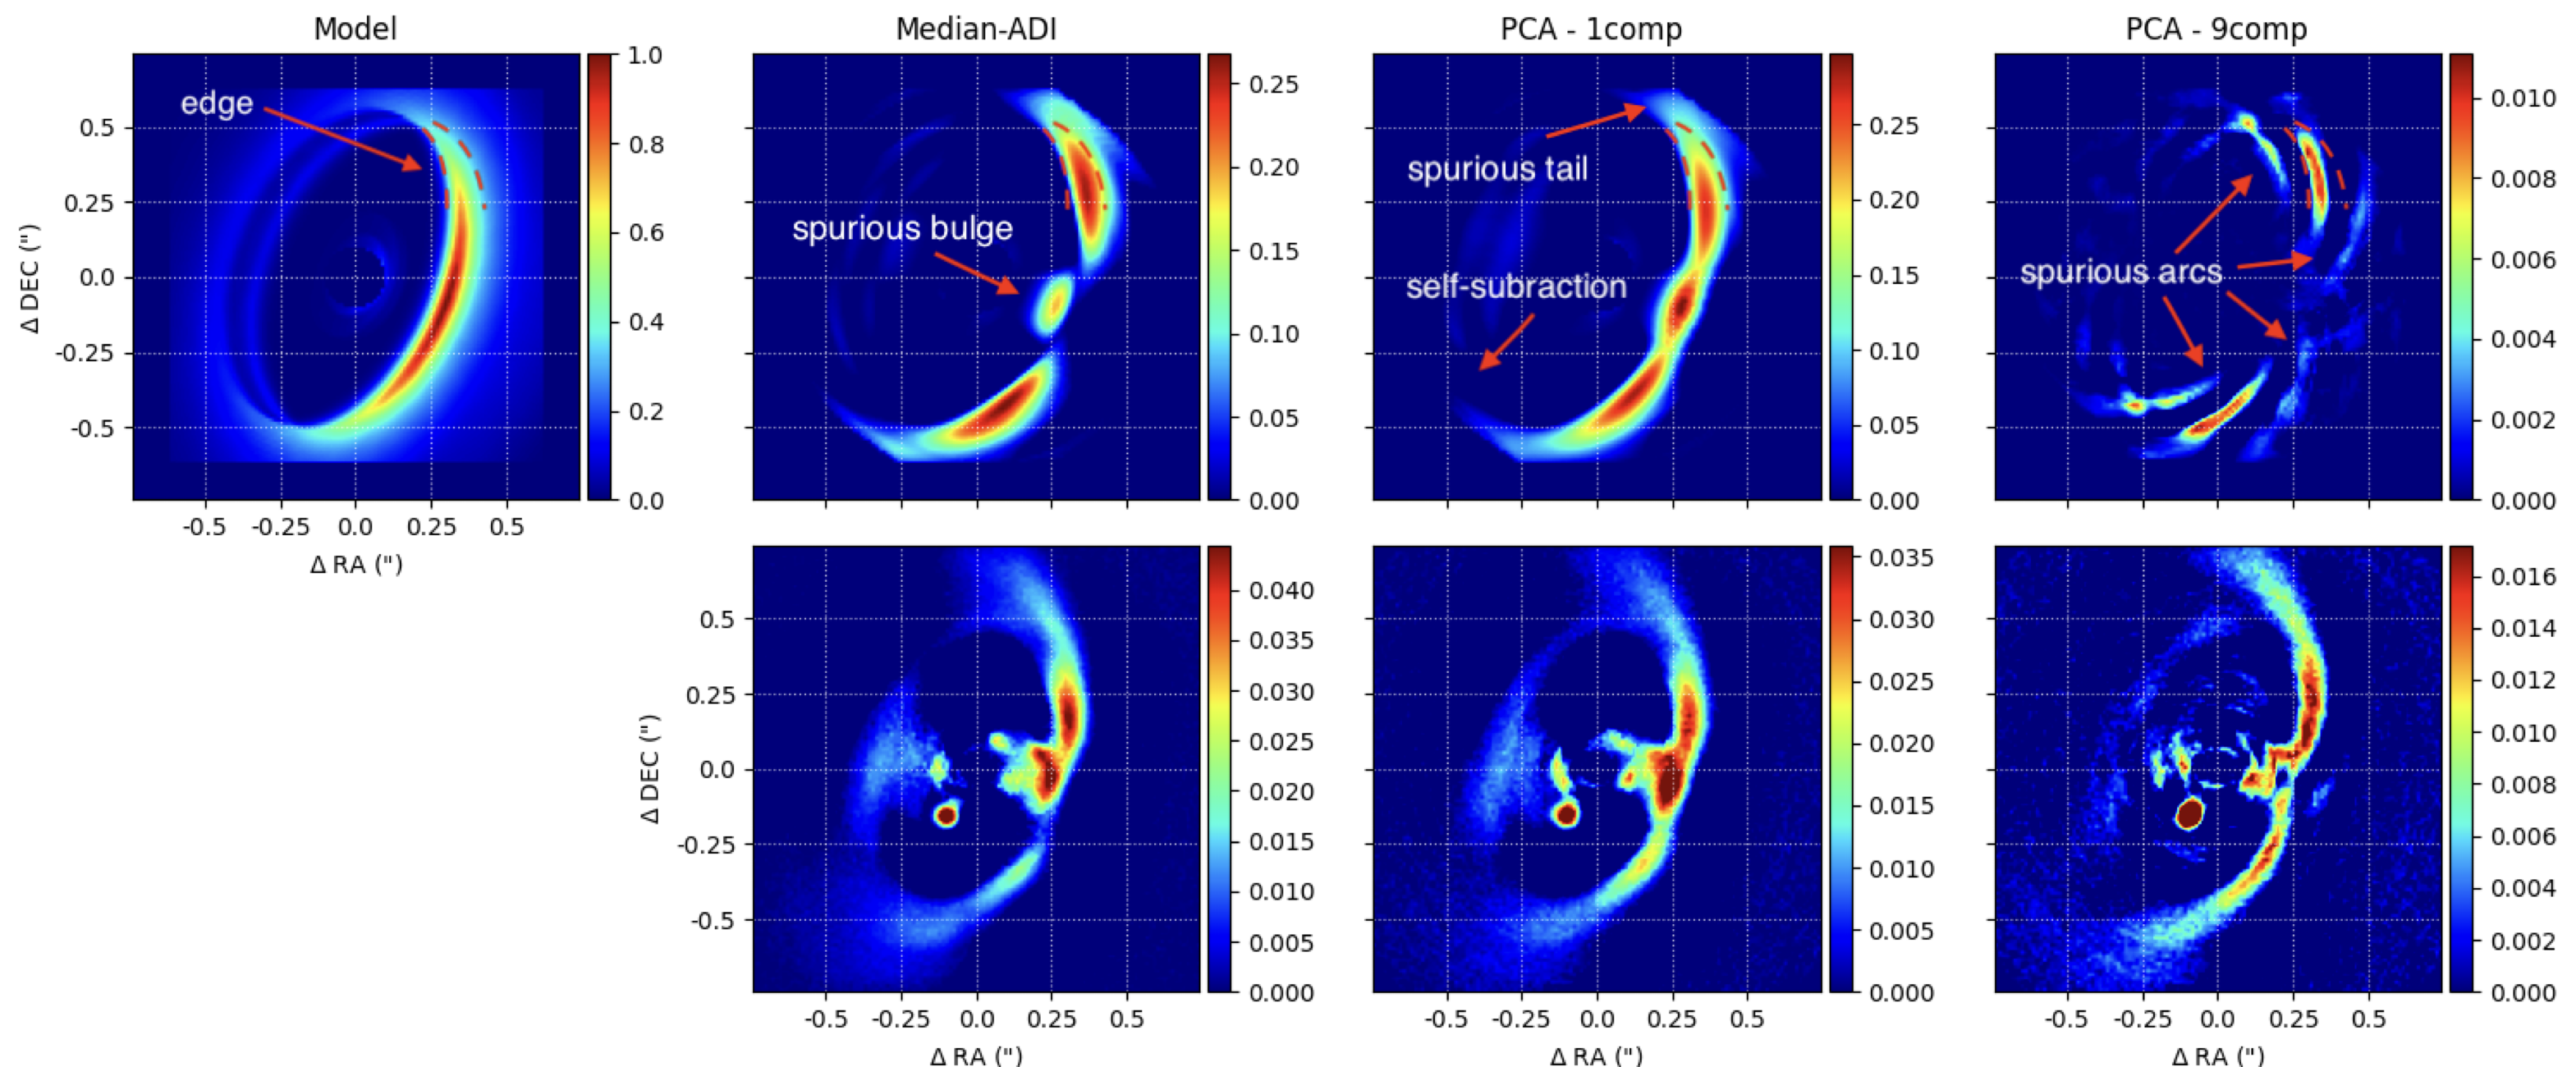
(Figure from [Juillard et al. 2022](https://ui.adsabs.harvard.edu/abs/2022A%26A...668A.125J/abstract))

Alternative strategies based on inverse-problem approaches have also been proposed in the literature and will not be explored in this section. We refer the interested reader to [Juillard et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..52J/abstract) for a comparison and discussion of inverse-problem and iterative approaches.

### 6.3.1. PCA with data imputation

(TBD: this section is pending a better example dataset, e.g. from the Ren et al. 2023 sample)

Now let's try the Principal Component Analysis (PCA)-based algorithms ([Amara & Quanz 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.427..948A/abstract), [Soummer et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...755L..28S/abstract)) in `vip.pca`.

We will more specifically use PCA-RDI with data imputation, as presented in [Ren (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..18R/abstract). We refer to that paper for the maths and nomenclature used in this section, including the concepts of anchor and boat masks. 

Let's first define a binary mask, with zeros covering the area of the image which could host circumstellar signals. Let's assume it covers the inner 20px radius:

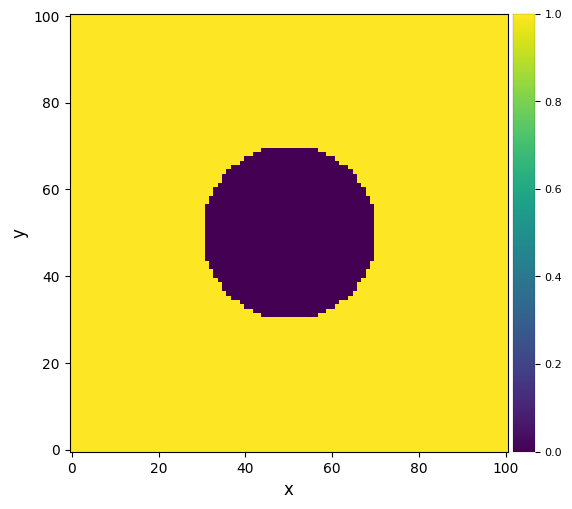

In [40]:
from vip_hci.var import mask_circle

anchor_mask = np.ones_like(cube[0])
anchor_mask = mask_circle(anchor_mask, 20)

plot_frames(anchor_mask)

Let's set to 30 the number of principal components `ncomp` considered for model creation, and let's run the PCA algorithm (feel free to test other values):

In [41]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi1 = anchor_mask   # can be a 2D bool array

fr_pca_di1 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi1, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 11:00:56
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.161 GB
Done de-rotating and combining
Running time:  0:00:00.640076
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


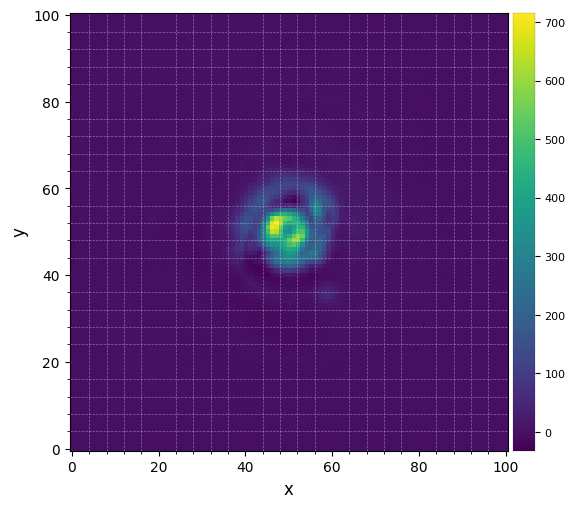

In [42]:
plot_frames(fr_pca_di1, grid=True)

There are strong residuals because the reference cube is not well correlated in this example.
A better approach would be to define 2 masks, anchor and boat masks, as in [Ren et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...679A..18R/abstract), where the boat mask only covers the relevant part of the field of view you are interested in (e.g. mask the IWA of the coronagraph or the areas too far out in the field).

In the case of a single mask as above, it is assumed to correspond to the anchor mask, and that the boat mask simply covers the full image.

Let's consider more sophisticated annular masks than above, and leverage the `get_annulus_segments` utility function in VIP:

In [43]:
from vip_hci.var import get_annulus_segments
get_annulus_segments?

Signature:
get_annulus_segments(
    data,
    inner_radius,
    width,
    nsegm=1,
    theta_init=0,
    optim_scale_fact=1,
    mode='ind',
    out=False,
)
Docstring:
Return indices or values in segments of a centered annulus.

The annulus is defined by ``inner_radius <= annulus < inner_radius+width``.

Parameters
----------
data : 2d numpy ndarray or tuple
    Input 2d array (image) ot tuple with its shape.
inner_radius : float
    The inner radius of the donut region.
width : float
    The size of the annulus.
nsegm : int
    Number of segments of annulus to be extracted.
theta_init : int
    Initial azimuth [degrees] of the first segment, counting from the
    positive x-axis counterclockwise.
optim_scale_fact : float
    To enlarge the width of the segments, which can then be used as
    optimization segments (e.g. in LOCI).
mode : {'ind', 'val', 'mask'}, optional
    Controls what is returned: indices of selected pixels, values of
    selected pixels, or a boolean mask.
out : 

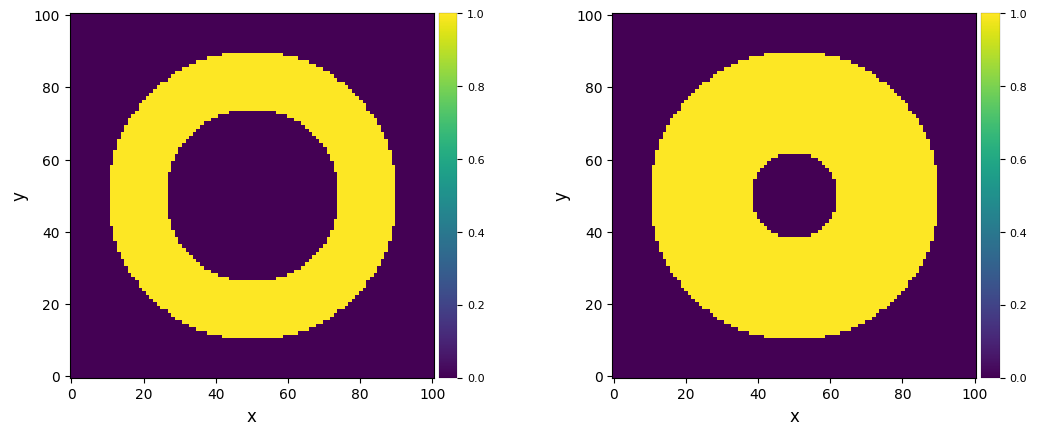

In [44]:
coro = 12    # discard signal within ~IWA of coronagraphic mask
ring_in = 24
ring_out = 40

ones = np.ones_like(cube[0])
anchor_mask = get_annulus_segments(ones, ring_in, ring_out-ring_in, mode="mask")[0]
boat_mask = get_annulus_segments(ones, coro, ring_out-coro, mode="mask")[0]

plot_frames((anchor_mask, boat_mask))

In [45]:
from vip_hci.psfsub import pca
ncomp = 30

mask_rdi2 = (anchor_mask, boat_mask)   # can be a tuple of 2 2D bool array

fr_pca_di2 = pca(cube, angs, ncomp=ncomp, cube_ref=cube_ref, mask_rdi=mask_rdi2, svd_mode=svd_mode, nproc=nproc)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-02-26 11:00:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 3.408 GB
Done de-rotating and combining
Running time:  0:00:00.608655
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


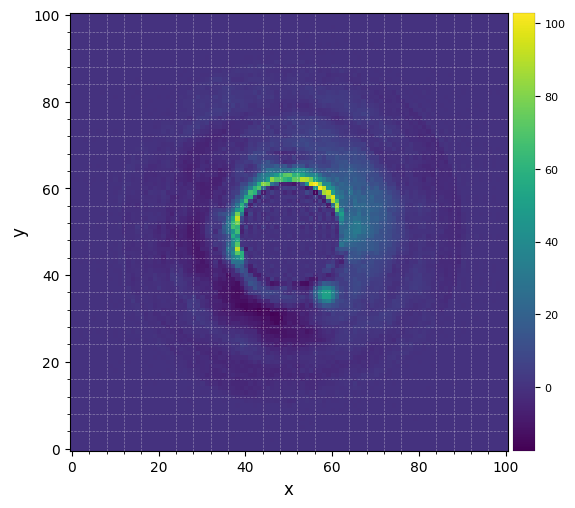

In [46]:
plot_frames(fr_pca_di2, grid=True)

### 6.3.2. Iterative PCA

In this section we will consider the application of iterative PCA to different datasets, and illustrate the different variants available within VIP.

#### 6.3.2.1. NACO dataset on beta Pic

Although the NACO dataset obtained with the vortex coronagraph on beta Pic does not achieve the required sensitivity to image the debris disk, this does not prevent IPCA to be applied to correct for the effects of self- and over-subtraction on planet b.

**IPCA-ADI**

In case you do not possess a library of reference PSF images that are correlated enough with your science PSF images, you can carry out iterative PCA using your science cube alone, as long as it presents some angular diversity (i.e. IPCA-ADI). Note however that in such case you may not always be able to fully recover the circumstellar signals that are invariant to rotation.

In [47]:
from vip_hci.greedy import ipca

The call is made in a similar fashion as for `pca`. In the example below, for 15 iterations requested with a fixed number of principal components (e.g. 20), it is simply a matter of setting the `nit` argument to 15:

In [48]:
fr_ipca_ADI = ipca(cube=cube, angle_list=angs, ncomp=20, nit=15,
                   svd_mode=svd_mode, nproc=nproc)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:58


Let's plot the result, masking the inner 1 FWHM:

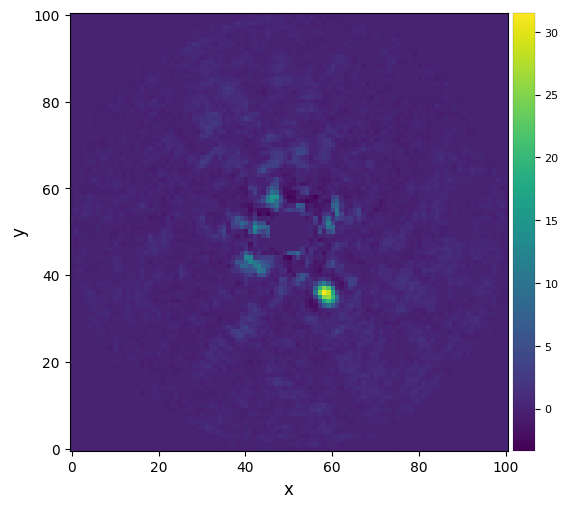

In [49]:
from vip_hci.var import mask_circle
plot_frames(mask_circle(fr_ipca_ADI, fwhm_naco))#, grid=True)

The negative side lobes which are typical of companions in ADI-processed images have almost entirely disappeared, and IPCA-ADI recovered a significant fraction of the flux which was self-subtracted.

The result above is not too bad, but some noise near the center of the image was propagated -- as by default all positive signals are propagated. Let's set a threshold to only try propagating significant signals.
To check more outputs, including the cube of images obtained at each iteration, let's also set `full_output=True` in the call:

In [50]:
res_ipca_ADI_thr = ipca(cube=cube, angle_list=angs, 
                        ncomp=15, nit=20, thr=1,
                        strategy='ADI',
                        svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##################            ] 100% | ETA: 00:00:29

You'll notice above that despite requesting for 20 iterations, the routine stopped after 10 iterations. Inside the function, a check is made after each new iteration to determine whether the new iteration brought a change to the estimated circumstellar signals or not. This can be controlled with the `atol` and `rtol` absolute and relative tolerances, respectively, which are provided as input to `np.allclose` when comparing consecutive interations to determine whether the images are different element-wise. These are both set by default to 0.01.

In [51]:
fr_ipca_ADI_thr, it_cube_ADI_thr, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ADI_thr

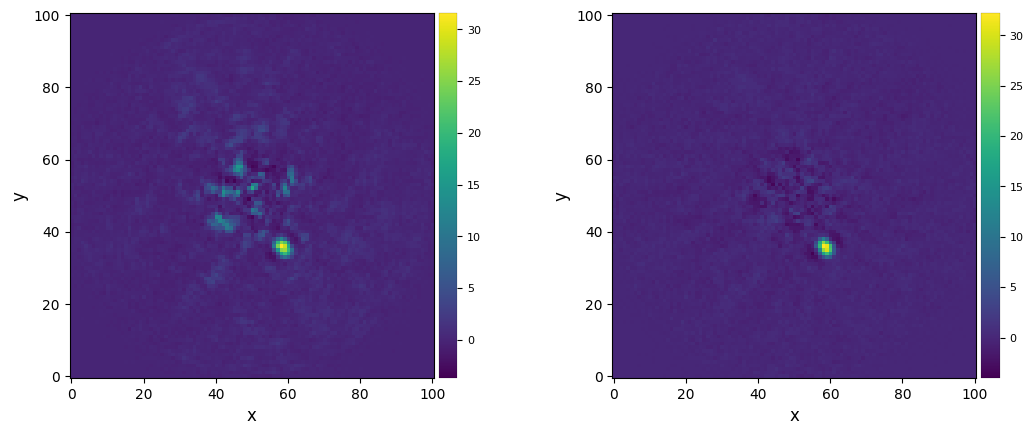

In [52]:
%matplotlib inline
plot_frames((fr_ipca_ADI, fr_ipca_ADI_thr))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 14]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
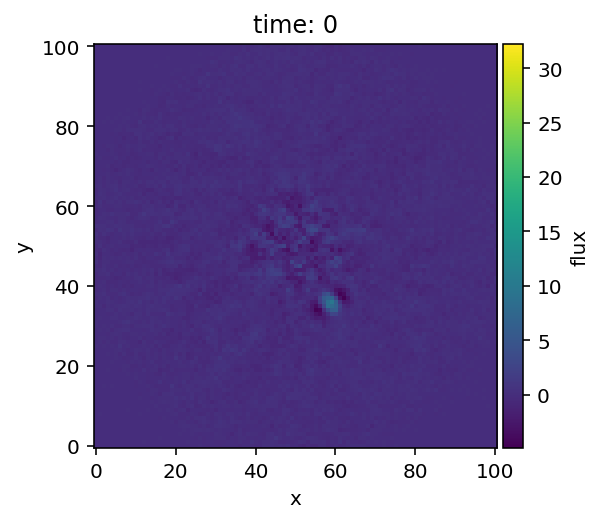

In [53]:
plot_cubes(it_cube_ADI_thr, grid=True)

In [54]:
res_ipca_ADI_incr = ipca(cube=cube, angle_list=angs, mask_center_px=5,
                         ncomp=30, nit=10, strategy='ADI', mode='Pairet21', 
                         svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:20:14


In [55]:
fr_ipca_ADI_incr, it_cube_ADI_incr, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ADI_incr

Let's compare with the other 2 variants considered earlier:

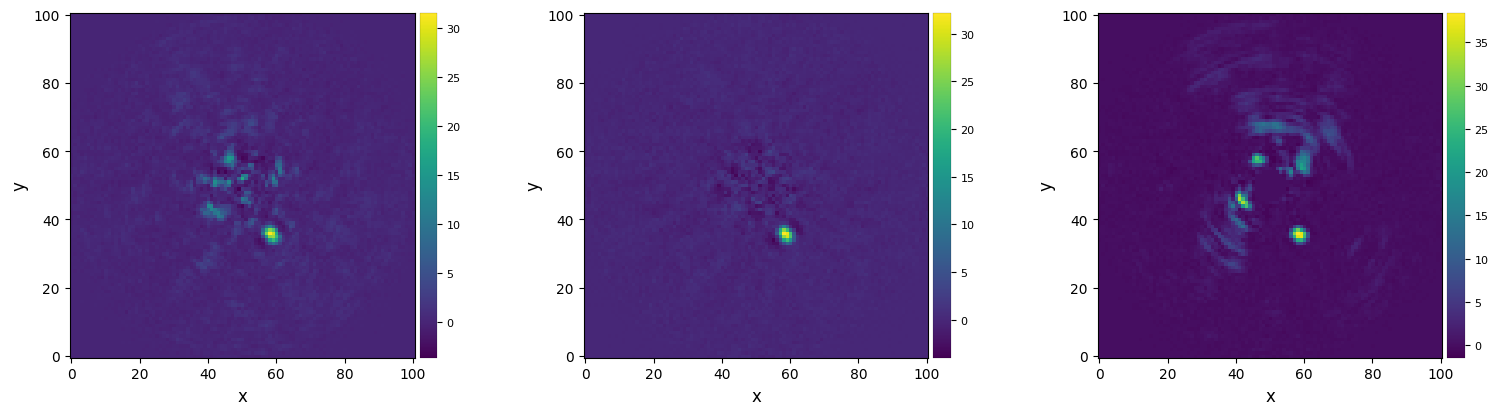

In [56]:
%matplotlib inline
plot_frames((fr_ipca_ADI, fr_ipca_ADI_thr, fr_ipca_ADI_incr))

Let's now consider both a threshold and incrementing the number of principal component along with the iterations to only propagate significant signals. Let's also mask the part of the stellar PSF that is saturated, using the `mask_center_px` argument.

In [57]:
res_ipca_ADI_incr_C24 = ipca(cube=cube, angle_list=angs, mask_center_px=5,
                         ncomp=30, nit=10, ncomp_start=5, 
                         thr=1, strategy='ADI', mode='Christiaens24', 
                         svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:11:42


In [58]:
fr_ipca_ADI_incr_C24, it_cube_ADI_incr_C24, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ADI_incr_C24

Let's compare with the previous variants:

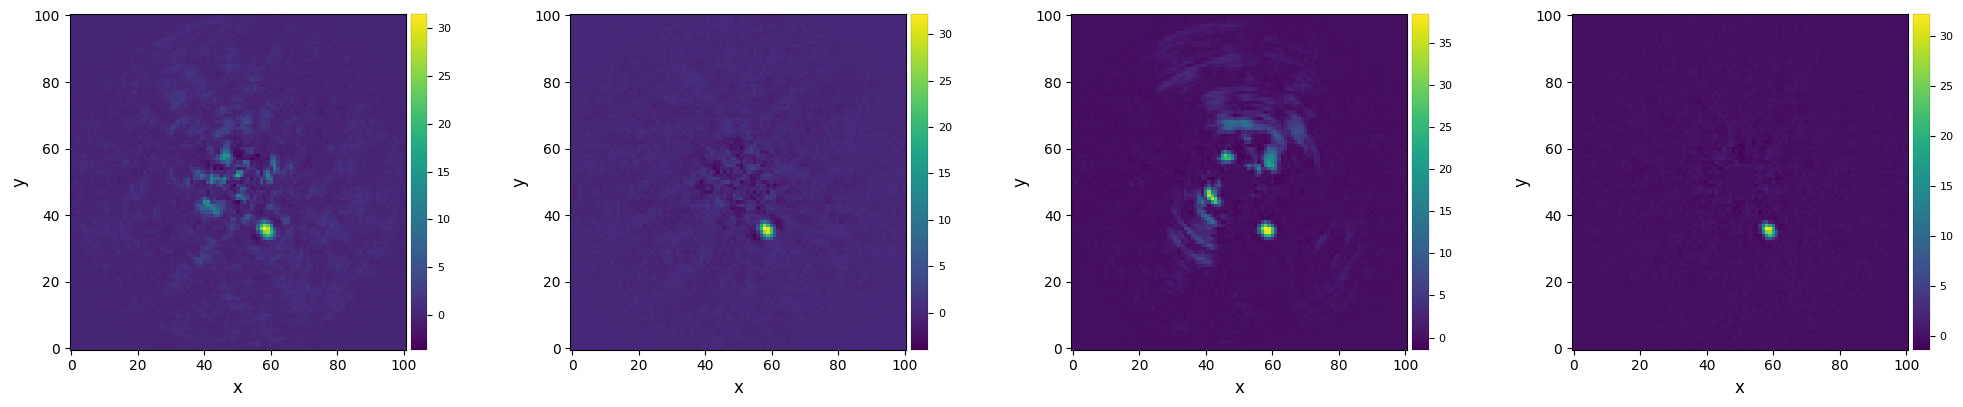

In [59]:
%matplotlib inline
plot_frames((fr_ipca_ADI, fr_ipca_ADI_thr, fr_ipca_ADI_incr, fr_ipca_ADI_incr_C24))

With this last example we see how incremental IPCA can further reduce the noise level while correcting, leading. Note that in this trivial example of a single point source in the field, it was easy to identify an adequate threshold and avoid any noise propagation. This may not be as easy nor sometimes even possible in general when trying to recover faint extended signals.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 260]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
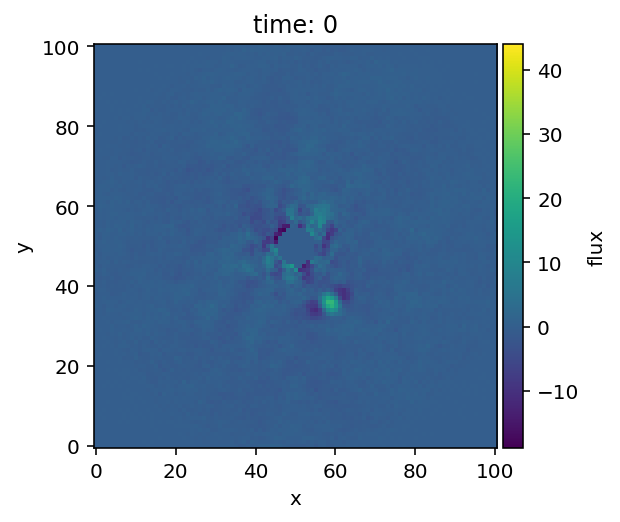

In [60]:
plot_cubes(it_cube_ADI_incr_C24, grid=True)

**IPCA-ARDI**

[Juillard et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024A%26A...688A.185J/abstract) showed that an iterative PCA algorithm leveraging both ADI and RDI together was one of the most robust way to reliably recover extended circumstellar signals, even outperforming PCA or NMF with data imputation.

The `GreeDs` implementation of IPCA, described in Juillard et al. (2024), is available [here](https://github.com/Sand-jrd/GreeDS). This is a fast and robust implementation of IPCA in `pytorch`. Provided that you have `pytorch` installed in your environment, this implementation can be called with the `ipca` function of VIP by setting `mode='Juillard23'`. The interested reader is referred to the [GreeDs package](https://github.com/Sand-jrd/GreeDS) for more details.

In the next few cells, let's explore the functionalities of the `ipca` function of VIP that are compatible with the ARDI strategy. First let's consider a constant number of PCs used throughout the iterations. The number of iterations is set by `nit`.

In [61]:
from vip_hci.greedy import ipca

res_ipca_ARDI = ipca(cube=cube, angle_list=angs, ncomp=20, nit=20, cube_ref=cube_ref,
                     strategy='ARDI', svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:20


In [62]:
fr_ipca_ARDI, it_cube_ARDI, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI

Let's plot the result, masking the inner 1 FWHM:

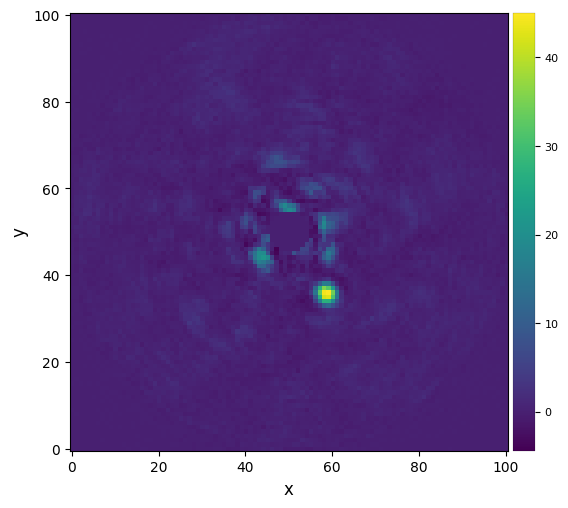

In [63]:
%matplotlib inline
plot_frames(mask_circle(fr_ipca_ARDI, fwhm_naco))

The above image shows that the negative side lobes which are typical of companions in ADI-processed images have disappeared, and that IPCA-ARDI recovered well the full PSF of the planet (we even start to distinguish it's first Airy ring). Let's visualize below how this happened throughout the iterations:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 20]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
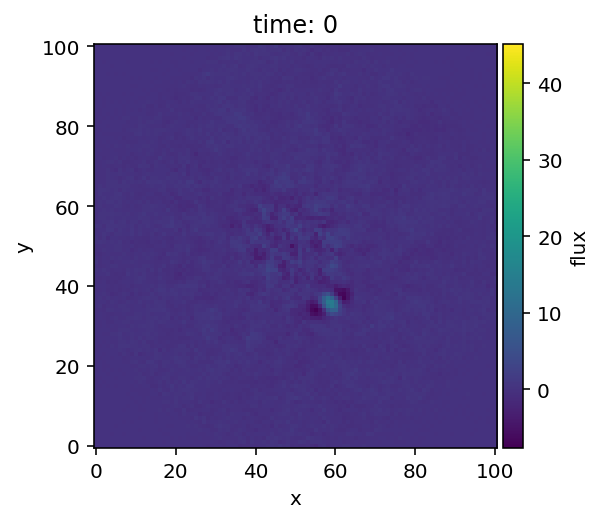

In [64]:
plot_cubes(it_cube_ARDI, grid=True)

In some cases, it can be beneficial to increment the number of PCs as the iterations increase, instead of using a fixed number of PCs for all iterations. This can be done by setting `mode='Pairet21'`. In this case `ncomp` sets the final number of PCs at the last iteration, and `nit` is the number of iterations with each tested number of PCs, starting with 1 PC:

In [65]:
from vip_hci.greedy import ipca

res_ipca_ARDI_incr_P21 = ipca(cube=cube, angle_list=angs, ncomp=42, nit=5, cube_ref=cube_ref, strategy='ARDI', 
                              mode='Pairet21', svd_mode=svd_mode, nproc=nproc, full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:14:54


In [66]:
fr_ipca_ARDI_incr_P21, it_cube_ARDI_incr_P21, _, _, _, _, _ = res_ipca_ARDI_incr_P21

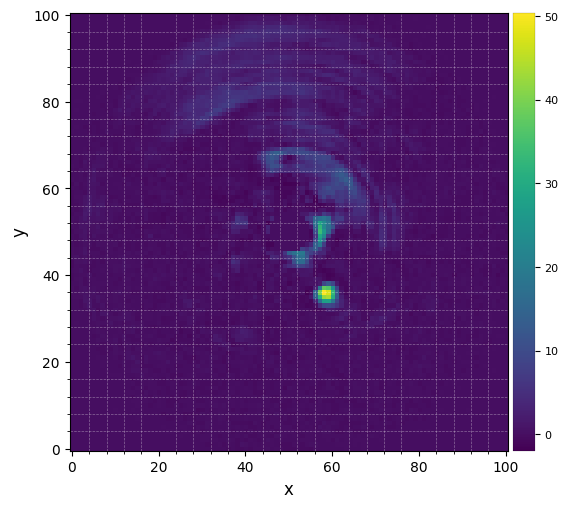

In [67]:
%matplotlib inline
plot_frames(mask_circle(fr_ipca_ARDI_incr_P21, fwhm_naco), grid=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 210]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
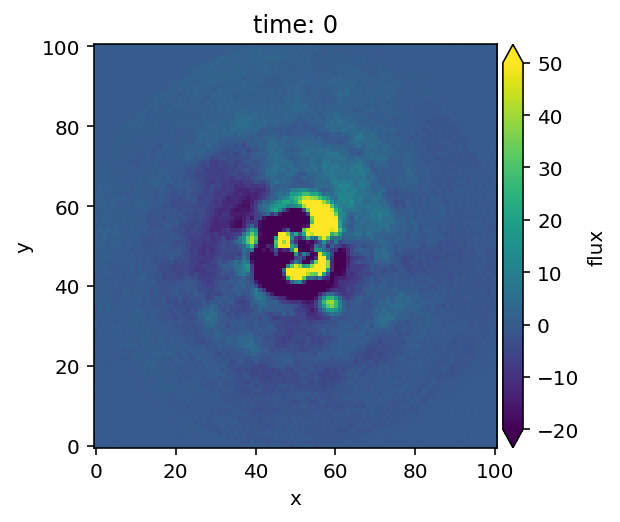

In [68]:
plot_cubes(it_cube_ARDI_incr_P21, grid=True, vmin=-20, vmax=50)

One takes the risk of propagating circular artefacts when starting at too low a number of principal components (which is by default 1), and considering all positive signals in the image at each iteration (also the default behaviour).
It is possible to set both the starting number of PCs (`ncomp_start`) and a threshold (`thr`) in `mode='Christiaens24'` to mitigate noise propagation:

In [69]:
res_ipca_ARDI_incr_C24 = ipca(cube=cube, angle_list=angs, cube_ref=cube_ref,
                              ncomp=25, nit=10, ncomp_start=10, thr=1,
                              strategy='ARDI', mode='Christiaens24', 
                              svd_mode=svd_mode, nproc=nproc, full_output=True)


Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:04:50


In [70]:
fr_ipca_ARDI_incr_C24, it_cube_ARDI_incr_C24, _, _, _, _, _ = res_ipca_ARDI_incr_C24

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 160]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
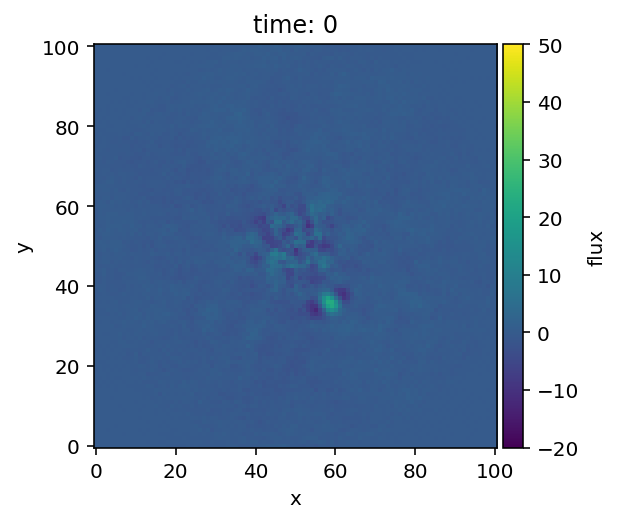

In [71]:
plot_cubes(it_cube_ARDI_incr_C24, grid=True, vmin=-20, vmax=50)

Let's compare the results:

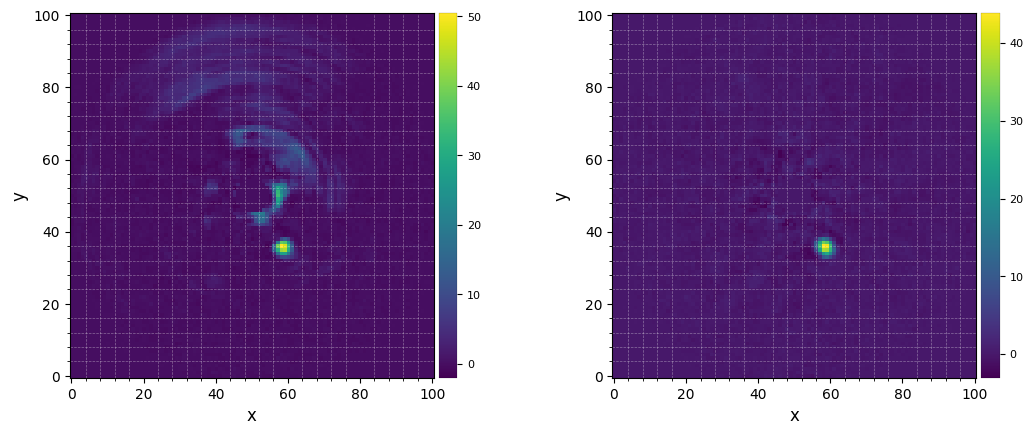

In [72]:
%matplotlib inline
plot_frames((mask_circle(fr_ipca_ARDI_incr_P21, fwhm_naco),
             mask_circle(fr_ipca_ARDI_incr_C24, fwhm_naco)), grid=True)

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The threshold `thr` can either be a threshold in terms of normalized STIM map (see Tuto 4), or an absolute threshold in terms of pixel intensity in the post-processed image. The behaviour is determined by the `thr_mode` argument, which is by default set to `'STIM'`, but can instead be set to `'abs'`.

In the example above, we set the threshold to be 1 without specifying `thr_mode`, which implictly meant that at each iteration, we only considered pixels whose value in the normalized STIM map is larger than 1 as containing circumstellar signal that is subtracted from the images used in the PCA library in the next iteration. 
This works well for compact signals, but may not work well in presence of extended circumstellar signals covering a significant fraction of the field, or when not much rotation is present in the dataset.
</div>

The effectiveness of **IPCA-ARDI combined with data imputation** at the first iteration is currently being investigated as a potential improvement to IPCA-ARDI alone (Kulkarni et al. in prep.). This mode can be activated by setting the `strategy` to 'ARDI' and providing a mask (or tuple of masks) to the `mask_rdi` argument. If `mode` is left to None, a constant number of principal components `ncomp` is used for `nit` iterations, while `mode='Pairet21'` or `mode='Christiaens24'` will incrementally increase the number of PCs from `ncomp_start` to `ncomp` every `nit`.

In [73]:
from vip_hci.greedy import ipca

res_ipca_ARDI_di = ipca(cube=cube, angle_list=angs, ncomp=30, nit=10, cube_ref=cube_ref,
                        strategy='ARDI', ncomp_start=10, mask_rdi=mask_rdi2, mode='Christiaens24', 
                        svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:14:30


An internal criterion of convergence exists, and if met the algorithm can stop earlier than the requested number of iterations. The convergence criterion can be adapted with arguments `rtol` and `atol`, the relative and absolute tolerance, respectively, which concerns the difference between the images of 2 consecutive iterations.

In [74]:
fr_ipca_ARDI_di, it_cube_ARDI_di, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_ARDI_di

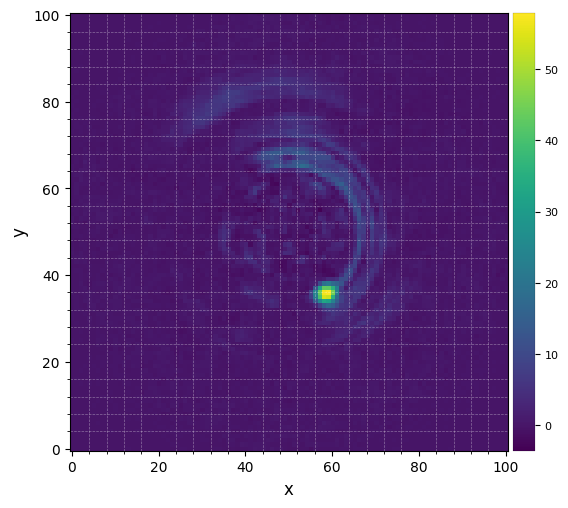

In [75]:
%matplotlib inline
plot_frames(fr_ipca_ARDI_di, grid=True)

In this case, more noise seems to be propagated. This highlights the importance of having an appropriate reference PSF for this approach to be effective (data imputation + IPCA-ARDI).

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[101, 101, 210]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
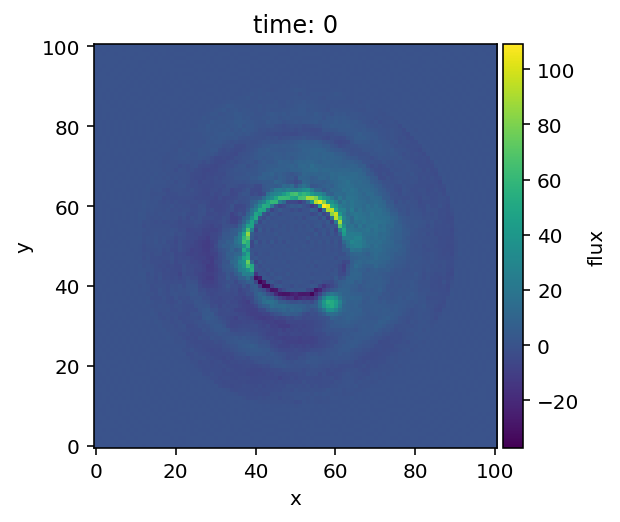

In [76]:
plot_cubes(it_cube_ARDI_di, grid=True)

#### 6.3.2.2. JWST/NIRCam dataset on PDS 70

Let's now turn our attention to the NIRCam data on PDS 70, published in [Christiaens et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024A%26A...685L...1C/abstract). 
The preprocessed data cube consist of 2 images corresponding to 2 different roll angles separated by only 5 deg.
Images were obtained in 2 filters: F187N and F480M, centered at 1.87 and 4.8 µm respectively.

**Iterative roll subtraction on the F187N images**

Before considering IPCA, let us consider iterative roll subtraction. The principle is straightforward: for a datacube of images obtained at only 2 roll angles, use directly the mean image obtained at the second angle as model for the images obtained at the first angle, and vice-versa, then mean-combine the 2 derotated residual images. At each new iteration, then consider the positive signals in the post-processed image, and subtract them (after rotation) from the 2 original images used as model PSF images. This is implemented in the `iroll` function of VIP.

Let's consider 1000 iterations:

In [77]:
nit = 1000

Either roll subtraction or classical ADI-based algorithms filter extended signals. Besides geometric artefacts, the resulting signals can look narrower than what would be expected from the natural convolution with the PSF of the instrument. To compensate for this filtering effect, and also more quickly recover all circumstellar signals one can convolve the post-processed at each image by a Gaussian kernel through the `smooth_ker_aft` argument.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

As a rule of thumb, setting the `smooth_ker_aft` to a number of pixels equal to half a resolution element leads to good results with NIRCam. In the case of F187N data, this is 2px/2 ~ 1px.
</div>

In [78]:
smooth_ker_aft= 1. # Gaussian kernel for smoothing

In [79]:
from vip_hci.greedy import iroll

res_iroll_f187n = iroll(cube=cube_f187, angle_list=angs_f187, 
                        nit=nit, nproc=nproc, smooth_ker_aft=smooth_ker_aft,
                        full_output=True, verbose=False)

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

The `smooth_ker_aft` argument can also accept the PSF of the instrument. However, this may not be the best choice. While the extended signals may be filtered, these are not down to single-pixel width -- which means convolving with the PSF will broaden the signals too much.
</div>

Let's extract the results. The last 2 outputs are the final image and cube of all iterations, respectively:

In [80]:
_, _, fr_iroll_f187n, it_cube_f187n = res_iroll_f187n

Let's compare the result obtained with regular roll subtraction (i.e. the very first iteration), and the image obtained with iterative roll subtraction:

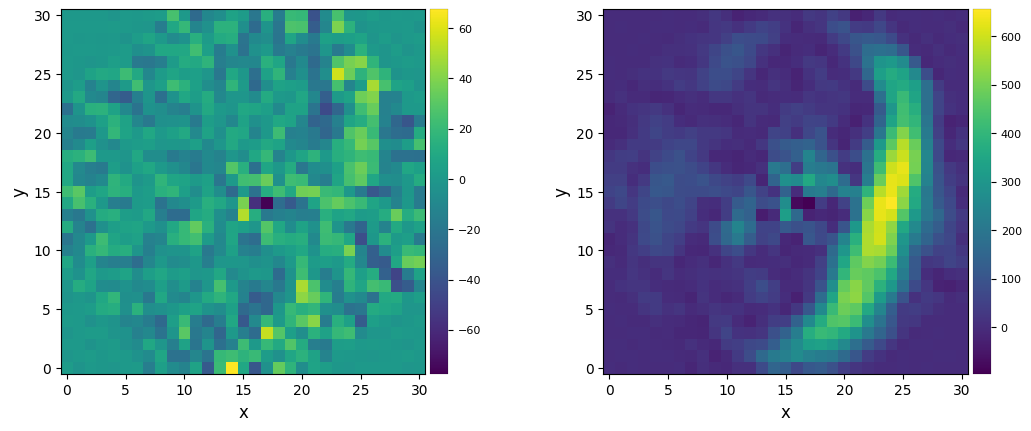

In [81]:
%matplotlib inline
plot_frames((it_cube_f187n[0], fr_iroll_f187n))

The iterative process has well recovered the disk - note the difference in pixel intensities. Planet b can also be distinguished in the cavity, maybe candidate d as well. But can we do better?

**IPCA-ADI on the F187N images**

Let's now consider IPCA instead of IROLL. In this case, the difference between the 2 algorithms is very subtle, since in either cases for each image the other image is used as model. While IROLL directly considers the other image as model, IPCA first normalize and finds the optimal projection factor (i.e. scale) applied. If there is some variability between the flux in the 2 images -- be it associated to astrophysical variability or to photon noise -- IPCA can lead to slightly better results.

<div class="alert alert-block alert-info"> 
    <b>Note: </b>
<a class="anchor" id="note1"></a>

In general, a larger PCA library is beneficial for a better modeling of the science PSF images, as long as the PSF images in the library are correlated with the science PSF images. Nonetheless,  the extreme stability of the NIRCam PSF cause almost all the variance to be captured in the first principal component even when considering all individual images before collapse into 1 mean-combined image per roll angle (>99.9% of cumulative explained variance!). Furthermore the remaining very small differences between images may not be well reproduced by a linear combination of components (e.g. if associated with detector undersampling or Gibbs artefacts stemming from FFT-based image shifts). Therefore, mean-combining all images obtained at the different dither positions into a single image per roll angle, thereby averaging out the effects of detector undersampling and Gibbs artefacts, leads to better results.
</div>

Given that there are only 2 different roll angles, we will make use of the `delta_rot` and `source_xy` arguments of the (i)pca function to specify that the PCA model for the image acquired at the first roll angle is made from the image acquired at the second roll angle, and vice-versa.

In [82]:
from vip_hci.var import frame_center
cx, cy = frame_center(cube_f187)  # here we leverage the VIP utility returning the center coordinates of a cube or image
source_xy = (cx, cy+5)
delta_rot = 0.1

Here what matters is that the `delta_rot` threshold is small (because of only 5 deg rotation) but non-zero, for a test position a few pixels away from the center for the selection to successfully operate (see more details in Tutorial 03).

In this special case, we also need to change the default value for the `min_frames_pca` 

In [83]:
min_frames_pca = 1  # reduce the default min number of frames for PCA library to avoid bug

In [84]:
nit=1000

In [85]:
res_ipca_f187n = ipca(cube=cube_f187, angle_list=angs_f187, 
                      ncomp=1, nit=nit, delta_rot=delta_rot,
                      min_frames_pca=min_frames_pca, smooth_ker=1.,
                      source_xy=source_xy, svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [##########                    ] 100% | ETA: 00:02:04

In [86]:
fr_ipca_f187n, it_cube_f187n, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_f187n

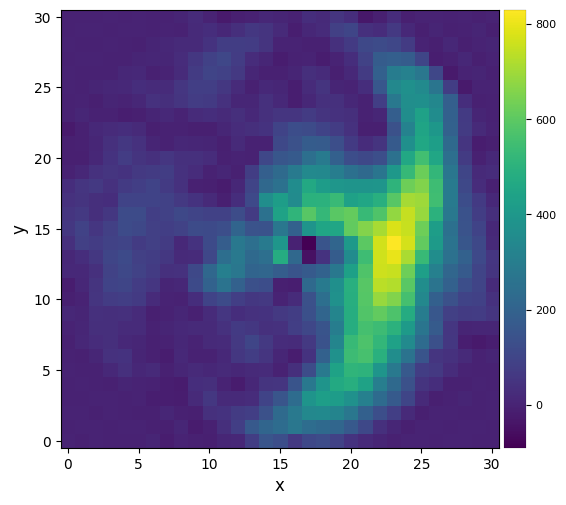

In [87]:
%matplotlib inline
plot_frames(fr_ipca_f187n)

To reduce noise propagation, one can set a threshold via `thr`. Contrary to the beta Pic example, let's now consider an absolute pixel intensity threshold, by setting `thr_mode='abs'`. Based on the PCA image (without iteration) above, let's set the threshold to 5.

In [88]:
res_ipca_f187n = ipca(cube=cube_f187, angle_list=angs_f187, 
                      ncomp=1, nit=300, strategy='ADI', delta_rot=delta_rot,
                      min_frames_pca=min_frames_pca, smooth_ker=1., thr=5, thr_mode='abs',
                      source_xy=source_xy, svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [########################      ] 100% | ETA: 00:00:08

**IPCA-ADI on the F480M images**

We can do the same with the F480M image.

Note that we now set `smooth_ker=1.2`, as a resolution element in this band is ~2.4px.

In [89]:
res_ipca_f480m = ipca(cube=cube_f480, angle_list=angs_f480, 
                      ncomp=1, nit=1000, strategy='ADI', delta_rot=delta_rot,
                      min_frames_pca=min_frames_pca, smooth_ker=1.2, thr=1, thr_mode='abs',
                      source_xy=source_xy, svd_mode=svd_mode, nproc=nproc, full_output=True)

Iterating...
0% [#######                       ] 100% | ETA: 00:01:50

In [90]:
fr_ipca_f480m, it_cube_f480m, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_f480m

Let's compare the regular roll subtraction with the result from iterative roll subtraction:

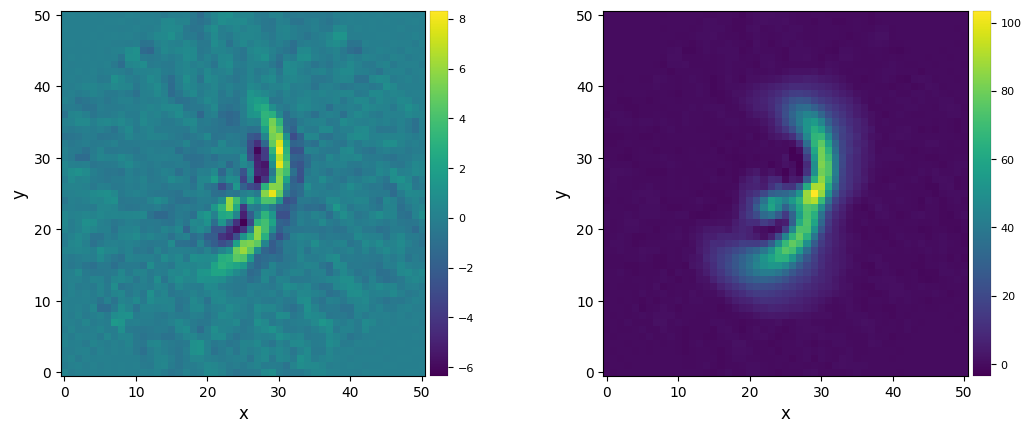

In [91]:
%matplotlib inline
plot_frames((it_cube_f480m[0], fr_ipca_f480m))#, vmax=800)

Smoothing the recovered circumstellar estimates may not recover the full original intensity. This may be a limitation of convolution with a kernel size that is not necessarily optimal.
Let's thus consider an extra option: further continue iterations without convolution, even after convergence is reached considering convolution.
This is triggered with `continue_without_smooth_after_conv = True`.

In [96]:
res_ipca_f480m_con = ipca(cube=cube_f480, angle_list=angs_f480, 
                      ncomp=1, nit=1000, strategy='ADI', delta_rot=delta_rot,
                      min_frames_pca=min_frames_pca, smooth_ker=1.6, thr=1, thr_mode='abs',
                      source_xy=source_xy, svd_mode=svd_mode, 
                      continue_without_smooth_after_conv=True,
                      nproc=nproc, full_output=True)

Iterating...
0% [####                          ] 100% | ETA: 00:02:11Convergence criterion met after 166 iterations...Smoothing turned off and iterating more
0% [####################          ] 100% | ETA: 00:00:39

In [97]:
fr_ipca_f480m_con, it_cube_f480m_con, sig_images, residuals_cube, residuals_cube_, stim_cube, it_cube_nd = res_ipca_f480m_con

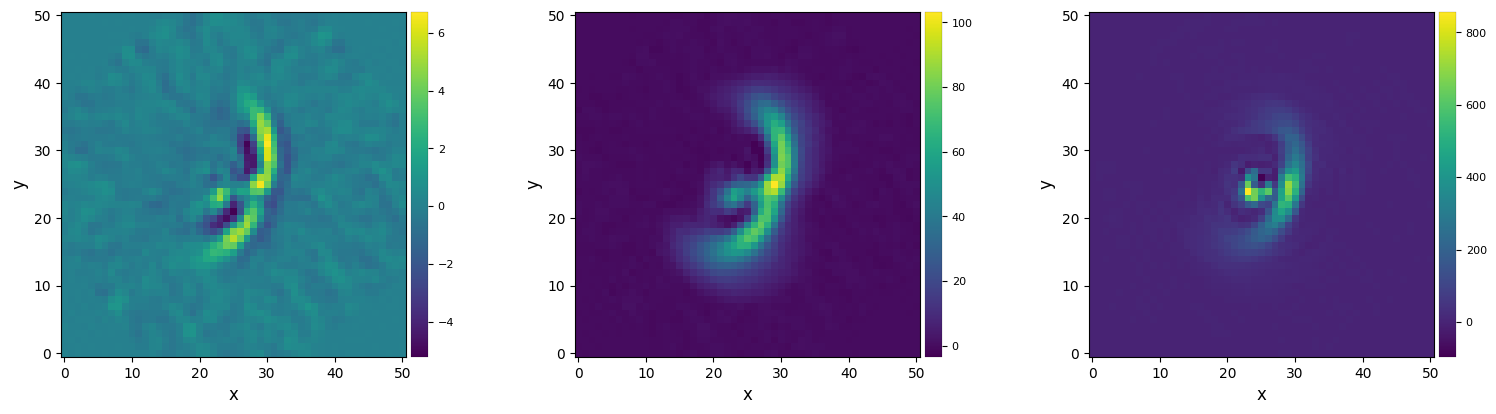

In [98]:
%matplotlib inline
plot_frames((it_cube_f480m_con[0], fr_ipca_f480m, fr_ipca_f480m_con))#, vmax=800)

This looks like the best we can do in terms of disk recovery. No geometric biases are left - an almost perfect ellipse for the outer disk, with some extra signals from the protoplanets and potentially the inner disk.

#### 6.3.2.3. Ks-band star hopping dataset 

In case you possess a library of reference PSF images that are highly correlated with your science PSF images, you may want to carry out iterative PCA using your reference cube alone (i.e. IPCA-RDI). This aims to correct for **over-subtraction**. IPCA-RDI can typically converge within a few iterations, as the absence of self-subtraction implies that the PCA-RDI image used at the first iteration will already be close to the final image (see e.g. the example in [Juillard et al. 2024](https://ui.adsabs.harvard.edu/abs/2024A%26A...688A.185J/abstract)). Note that if the reference PSF images are not very well correlated or your disk signals are simply fainter than the PSF residuals, you will end propagating noise artefacts.

(TBD: requires a good example dataset for illustration)